# Modelo Séries Temporais Agravos Sensiveis ao Clima SIH e WB - Treinamento

In [0]:
%pip install geobr keras matplotlib matplotlib-scalebar openpyxl xlsxwriter

  Obtaining dependency information for geobr from https://files.pythonhosted.org/packages/3b/f4/e6df7527589b91bcb054074d2a2e4ec827528006ae5d3523d228f8ef155e/geobr-0.2.2-py3-none-any.whl.metadata
  Obtaining dependency information for matplotlib-scalebar from https://files.pythonhosted.org/packages/a8/c0/2dfab7b319dabe23f5a7b515a797c74b501d15c72e7a03837cf0cf779b9e/matplotlib_scalebar-0.9.0-py3-none-any.whl.metadata
  Obtaining dependency information for openpyxl from https://files.pythonhosted.org/packages/c0/da/977ded879c29cbd04de313843e76868e6e13408a94ed6b987245dc7c8506/openpyxl-3.1.5-py2.py3-none-any.whl.metadata
  Obtaining dependency information for xlsxwriter from https://files.pythonhosted.org/packages/9b/07/df054f7413bdfff5e98f75056e4ed0977d0c8716424011fac2587864d1d3/XlsxWriter-3.2.2-py3-none-any.whl.metadata
  Obtaining dependency information for geopandas<=1.1,>=1.0.0 from https://files.pythonhosted.org/packages/c4/64/7d344cfcef5efddf9cf32f59af7f855828e9d74b5f862eddf5bfd9f2532

In [0]:
%restart_python

## Importação

### Importando pacotes

In [0]:
# Importando pacotes usados na análise
from datetime import datetime
from joblib import Parallel, delayed
from keras.layers import LSTM, Dense
from keras.models import Sequential
from matplotlib_scalebar.scalebar import ScaleBar
from pandas import ExcelWriter
from pmdarima import auto_arima
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric
from pyspark.ml.feature import StringIndexer
from pyspark.sql import functions as F, SparkSession
from pyspark.sql.functions import col, concat, countDistinct, create_map, current_date, datediff, expr, length, lit, lower, max, min, regexp_extract, regexp_replace, sum, to_date, trim, udf, when    
from pyspark.sql.types import DateType, IntegerType, StringType
from pyspark.sql.window import Window
from scipy import stats
from scipy.stats import f_oneway, norm,pearsonr, shapiro, zscore  
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_log_error, explained_variance_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from statsmodels.graphics.gofplots import qqplot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

import glob
import itertools
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np 
import pandas as pd
import pmdarima as pm
import os
import random
import seaborn as sns
import statsmodels.api as sm
import matplotlib.dates as mdates
import xgboost as xgb


2025-02-06 16:23:56.519547: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-06 16:23:56.673341: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-06 16:23:57.374105: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-06 16:24:03.492493: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2025/02/06 16:24:06 WARNING mlflow.tracking.fluent: Exception raised while enabling autologging for tensorflow: cannot import name 'cast' from partially initialized module 'keras.src.backend' (most likely due to a circular import) (/databricks/python/lib/python3.11/site-packa

### Importando dados

In [0]:
# Importando dados 
cid = spark.read.table("data_research_dev.raw_cid10.rotulos_cid_10")
cid_pandas = cid.toPandas()

sih_spark = spark.read.table("data_research_dev.raw_sih_sensiveis_clima.sih_microdados_individuais_2018_2023")
sih_pandas = sih_spark.toPandas()

sih_spark_group = spark.read.table("data_research_dev.raw_sih_sensiveis_clima.sih_dados_agrupados_municipios_2018_2023")
sih_pandas_group = sih_spark_group.toPandas()

wb_micro_spark = spark.read.table("data_research_dev.raw_acessos_wb.afya_grupotemas_wb_brasil")
wb_micro_pandas = wb_micro_spark.toPandas()

wb_micro_spark_group = spark.read.table("data_research_dev.raw_acessos_wb.afya_grupotemas_wb_microrregioes_arupado")
wb_micro_pandas_group = wb_micro_spark_group.toPandas()

wb_micro_spark_uf_group = spark.read.table("data_research_dev.raw_acessos_wb.afya_grupotemas_wb_estado")
wb_micro_pandas_uf_group = wb_micro_spark_uf_group.toPandas()

correspondencia_spark_cid = spark.read.table("data_research_dev.raw_cids_sensiveis_clima.lista_cids_selecionados_correspondencia_wb")
correspondencia_pandas_cid = correspondencia_spark_cid.toPandas()

projecao_populacional_spark = spark.read.table("data_research_dev.populacao_ibge.raw_projecao_populacao_ibge_uf")
projecao_populacional_pandas = projecao_populacional_spark.toPandas()

projecao_nacional_spark = spark.read.table("data_research_dev.populacao_ibge.raw_projecao_populacao_ibge")
projecao_nacional_pandas = projecao_nacional_spark.toPandas()

## Análise Descritiva

### Analise por sexo e faixa etária

In [0]:
# Função para criar a coluna de faixa etária
def criar_faixa_etaria(df, coluna_idade, nova_coluna):
    # Definindo os intervalos e os rótulos das faixas etárias
    bins = [-1, 1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, float("inf")]
    labels = ["<1", "1-5", "6-10", "11-20", "21-30", "31-40", "41-50", "51-60", "61-70", "71-80", "81-90", "90+"]
    # Criando a nova coluna
    df[nova_coluna] = pd.cut(df[coluna_idade], bins=bins, labels=labels, right=True)
    return df

In [0]:
# Criar a faixa etária na coluna 'FAIXA_ETARIA'
sih_pandas = criar_faixa_etaria(sih_pandas, coluna_idade="IDADE", nova_coluna="FAIXA_ETARIA")


In [0]:
# Criar a Tabela 1: Linhas (FAIXA_ETARIA) x Colunas (SEXO)
tabela_1 = (
    sih_pandas.groupby(["FAIXA_ETARIA", "SEXO"])["N_AIH"]
    .nunique()  # Contar valores únicos de N_AIH
    .reset_index()  # Resetar o índice para facilitar o pivot
    .pivot(index="FAIXA_ETARIA", columns="SEXO", values="N_AIH")  # Criar a tabela no formato solicitado
)

# Criar a Tabela 2: Linhas (DIAG_PRINC_NOME) x Colunas (SEXO)
tabela_2 = (
    sih_pandas.groupby(["DIAG_PRINC_NOME", "SEXO"])["N_AIH"]
    .nunique()  # Contar valores únicos de N_AIH
    .reset_index()  # Resetar o índice para facilitar o pivot
    .pivot(index="DIAG_PRINC_NOME", columns="SEXO", values="N_AIH")  # Criar a tabela no formato solicitado
)

# Criar a Tabela 3: Linhas (DIAG_PRINC_NOME) x Colunas (FAIXA_ETARIA)
tabela_3 = (
    sih_pandas.groupby(["DIAG_PRINC_NOME", "FAIXA_ETARIA"])["N_AIH"]
    .nunique()  # Contar valores únicos de N_AIH
    .reset_index()  # Resetar o índice para facilitar o pivot
    .pivot(index="DIAG_PRINC_NOME", columns="FAIXA_ETARIA", values="N_AIH")  # Criar a tabela no formato solicitado
)


In [0]:
# Função para adicionar total e calcular frequência e percentual
def adicionar_totais_e_percentuais(tabela, total_label="Total"):
    # Adicionar a linha com os totais
    tabela.loc[total_label] = tabela.sum(axis=0)
    
    # Calcular os percentuais
    percentuais = tabela.div(tabela.loc[total_label], axis=1) * 100
    
    # Renomear colunas para incluir frequência e percentual
    tabela_final = pd.concat([tabela, percentuais], axis=1)
    tabela_final.columns = [f"{col}_frequencia" if i < len(tabela.columns) / 2 else f"{col}_percentual" 
                            for i, col in enumerate(tabela_final.columns)]
    
    return tabela_final

In [0]:
# Recriar as tabelas com totais e percentuais

# Faixa Etária x Sexo
tabela_1_com_totais = adicionar_totais_e_percentuais(tabela_1)

# Diagnóstico x Sexo
tabela_2_com_totais = adicionar_totais_e_percentuais(tabela_2)

# Diagnóstico x Faixa Etária
tabela_3_com_totais = adicionar_totais_e_percentuais(tabela_3)


In [0]:
# Salvando as tabelas no caminho especificado
caminho_base = "/Workspace/Users/danielly.xavier@iclinic.com.br/Modelo Séries Temporais Clima e Saúde WB/Modelo Séries Temporais Clima e Saúde WB - Resultados/analise_descritiva_sih/dados_demograficos"

# Create the directory if it does not exist
os.makedirs(caminho_base, exist_ok=True)

# Tabela 1: Faixa Etária x Sexo
tabela_1_caminho = f"{caminho_base}tabela_faixaetaria_sexo_sih.xlsx"
tabela_1_com_totais.to_excel(tabela_1_caminho, index=True)

# Tabela 2: Diagnóstico x Sexo
tabela_2_caminho = f"{caminho_base}tabela_diagnostico_sexo_sih.xlsx"
tabela_2_com_totais.to_excel(tabela_2_caminho, index=True)

# Tabela 3: Diagnóstico x Faixa Etária
tabela_3_caminho = f"{caminho_base}tabela_diagnostico_faixaetaria_sih.xlsx"
tabela_3_com_totais.to_excel(tabela_3_caminho, index=True)

In [0]:
# Agrupar os dados por Faixa Etária e Sexo e contar os valores únicos de N_AIH
piramide_etaria = sih_pandas.groupby(["FAIXA_ETARIA", "SEXO"])["N_AIH"].nunique().unstack(fill_value=0)

# Separar os dados por sexo
masculino = piramide_etaria.get("M", pd.Series(index=piramide_etaria.index, data=piramide_etaria['Masculino']))
feminino = piramide_etaria.get("F", pd.Series(index=piramide_etaria.index, data = piramide_etaria['Feminino']))


# Configuração para o gráfico
faixas_etarias = piramide_etaria.index.astype(str)  # Converter índices para string
posicoes = np.arange(len(faixas_etarias))

# Criar o gráfico de pirâmide etária
plt.figure(figsize=(10, 8))
plt.barh(posicoes, -masculino, color="blue", label="Masculino")  # Valores negativos para a esquerda
plt.barh(posicoes, feminino, color="pink", label="Feminino")

# Configurações adicionais
plt.yticks(posicoes, faixas_etarias)
plt.xlabel("Número de Internações")
plt.ylabel("Faixa Etária")
plt.title("Pirâmide Etária de Internações")
plt.legend(loc="best")
plt.axvline(0, color="black", linewidth=0.5)  # Linha central

# Configurar o formato do eixo X para exibir números normalmente
plt.gca().xaxis.set_major_formatter(mticker.StrMethodFormatter("{x:.0f}"))

plt.tight_layout()

# Salvando a figura
plt.savefig("/Workspace/Users/danielly.xavier@iclinic.com.br/Modelo Séries Temporais Clima e Saúde WB/Modelo Séries Temporais Clima e Saúde WB - Resultados/analise_descritiva_sih/graficos/faixa_etaria.png")
plt.close()

# Exibir o gráfico
plt.show()

In [0]:
# Inicializando o DataFrame sih_spark
sih_spark = spark.read.table("data_research_dev.raw_sih_sensiveis_clima.sih_microdados_individuais_2018_2023")
populacao_df = spark.read.table("data_research_dev.populacao_ibge.raw_projecao_populacao_ibge")
populacao_df = populacao_df.withColumnRenamed("ANO", "ANO_POP").withColumnRenamed("POPULACAO", "POPULACAO_ANO")

# Garantir que a coluna ANO está presente em sih_spark
sih_spark = sih_spark.withColumn("ANO", F.year(F.col("DT_INTER")))

# Etapa 1: Agregar corretamente N_AIH
sih_spark = sih_spark.groupBy("DIAG_PRINC_NOME", "ANO").agg(F.count("N_AIH").alias("N_AIH"))

# Etapa 2: Calcular o total de internações por ano
window_ano = Window.partitionBy("ANO")
sih_spark = sih_spark.withColumn("Total_Ano", F.sum("N_AIH").over(window_ano))

# Etapa 3: Calcular percentual de internações por diagnóstico e ano
sih_spark = sih_spark.withColumn("Percentual", F.round((F.col("N_AIH") / F.col("Total_Ano")) * 100, 2))

# Etapa 4: Adicionar dados populacionais e calcular taxa
sih_spark = sih_spark.join(populacao_df, sih_spark["ANO"] == populacao_df["ANO_POP"], "left")
sih_spark = sih_spark.withColumn("Taxa", F.round((F.col("N_AIH") / F.col("POPULACAO_ANO")) * 100000, 2))

# Etapa 5: Incorporar Diagnóstico Secundário
diagnosticos_sec_df = spark.read.table("data_research_dev.raw_cids_sensiveis_clima.lista_cids_selecionados_correspondencia_wb")
diagnosticos_sec_df = diagnosticos_sec_df.select("DIAG_PRINC_NOME", "CATEGORIA_SECUNDARIA")
sih_spark = sih_spark.join(diagnosticos_sec_df, on="DIAG_PRINC_NOME", how="left")

# Etapa 6: Reorganizar tabela para o formato desejado
tabela_diagnostico_secundario = (
    sih_spark
    .select("DIAG_PRINC_NOME", "CATEGORIA_SECUNDARIA", "ANO", "N_AIH", "Percentual", "Taxa")
    .withColumnRenamed("N_AIH", "n")
    .groupBy("DIAG_PRINC_NOME", "CATEGORIA_SECUNDARIA")
    .pivot("ANO", [2021, 2022, 2023, 2024])
    .agg(F.first("n").alias("n"), F.first("Percentual").alias("Percentual"), F.first("Taxa").alias("Taxa"))
)

# Converta o DataFrame para Pandas
tabela_pandas = tabela_diagnostico_secundario.toPandas()

# Salvando as tabelas no caminho especificado
caminho_base = "/Workspace/Users/danielly.xavier@iclinic.com.br/Modelo Séries Temporais Clima e Saúde WB/Modelo Séries Temporais Clima e Saúde WB - Resultados/analise_descritiva_sih/dados_demograficos"

# Tabela 4: Diagnóstico x Ano com Diagnóstico Secundário
tabela_4_caminho = f"{caminho_base}tabela_diagnostico_secundario_sih.xlsx"

# Salvando a Tabela 4 no caminho especificado
with pd.ExcelWriter(tabela_4_caminho, engine="xlsxwriter") as writer:
    tabela_pandas.to_excel(writer, index=False, sheet_name="Tabela Diagnóstico Secundário")
    writer.save()

print(f"Tabela 4 salva em: {tabela_4_caminho}")

/root/.ipykernel/1398/command-5988092837395370-3900769390:50: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b62ad8ef-308e-4755-b4c7-aed34ada9c55/lib/python3.11/site-packages/xlsxwriter/workbook.py:377: UserWarning: Calling close() on already closed file.
  warn("Calling close() on already closed file.")


Tabela 4 salva em: /Workspace/Users/danielly.xavier@iclinic.com.br/Modelo Séries Temporais Clima e Saúde WB/Modelo Séries Temporais Clima e Saúde WB - Resultados/analise_descritiva_sih/dados_demograficostabela_diagnostico_secundario_sih.xlsx


### Ajuste de dados para a TS


In [0]:
#Transformando datas
sih_pandas_group['DT_INTER'] = pd.to_datetime(sih_pandas_group['DT_INTER'], format="%Y-%m-%d")

sih_pandas['DT_INTER'] = pd.to_datetime(sih_pandas['DT_INTER'], format="%Y-%m-%d")
sih_pandas['DT_INTER'] = pd.to_datetime(sih_pandas['DT_INTER'], format="%Y-%m-%d")
sih_pandas['DT_SAIDA'] = pd.to_datetime(sih_pandas['DT_SAIDA'], format="%Y-%m-%d")
sih_pandas['NASC'] = pd.to_datetime(sih_pandas['NASC'], format="%Y-%m-%d")

sih_pandas_group['DIAG_PRINC'] = np.where(
    sih_pandas_group['DIAG_PRINC_NOME'].str.contains('Pneumonia', case=False, na=False),
    'PNEUMONIA',
    sih_pandas_group['DIAG_PRINC']
)
sih_pandas_group['DIAG_PRINC_NOME'] = np.where(sih_pandas_group["DIAG_PRINC"] == "PNEUMONIA", 
                                               "Pneumonia", 
                                               sih_pandas_group["DIAG_PRINC_NOME"])

sih_pandas['DIAG_PRINC'] = np.where(
    sih_pandas['DIAG_PRINC_NOME'].str.contains('Pneumonia', case=False, na=False),
    'PNEUMONIA',
    sih_pandas['DIAG_PRINC']
)
sih_pandas['DIAG_PRINC_NOME'] = np.where(sih_pandas["DIAG_PRINC"] == "PNEUMONIA", 
                                               "Pneumonia", 
                                               sih_pandas["DIAG_PRINC_NOME"])

wb_micro_pandas['access_date'] = pd.to_datetime(wb_micro_pandas['access_date'], format="%Y-%m-%d")
wb_micro_pandas_group['data_acesso'] = pd.to_datetime(wb_micro_pandas_group['data_acesso'], format="%Y-%m-%d")

In [0]:
# Ajustando dados do Whitebook
wb_micro_spark_uf_group = wb_micro_spark_uf_group.withColumn(
    'content_main_theme',
    F.when(
        F.col('content_main_theme').rlike('(?i)pneumonia'),
        'PNEUMONIA'
    ).otherwise(F.col('content_main_theme'))
)

In [0]:
# Ajustando dados de correspondencia
correspondencia_spark_cid = correspondencia_spark_cid.withColumn(
    'DIAG_PRINC',
    when(
        lower(col('CATEGORIA_PRIMARIA')).contains('Pneumonia'),
        'PNEUMONIA'
    ).otherwise(col('DIAG_PRINC'))
)

correspondencia_spark_cid = correspondencia_spark_cid.withColumn(
    'CATEGORIA_PRIMARIA',
    when(
        col('DIAG_PRINC') == 'PNEUMONIA',
        'Pneumonia'
    ).otherwise(col('CATEGORIA_PRIMARIA'))
)

In [0]:
# Tratando dados de SIH com o dados de WB para união
sih_spark_group = sih_spark_group.withColumn('DT_INTER', F.to_date(F.col('DT_INTER'), 'yyyy-MM-dd'))
wb_micro_spark_group = wb_micro_spark_group.withColumn('data_acesso', F.to_date(F.col('data_acesso'), 'yyyy-MM-dd'))

# Selecionar apenas as colunas necessárias de 'correspondencia_spark_cid'
correspondencia_spark_cid_selected = correspondencia_spark_cid.select('DIAG_PRINC', 'CATEGORIA_PRIMARIA')

# Tratando dados para extração
sih_spark_group = sih_spark_group.withColumn("DIAG_PRINC", 
                                             when(length(col("DIAG_PRINC")) == 3, 
                                                  regexp_replace(col("DIAG_PRINC"), "$", "0"))  # Adicionar 0 ao final se tiver 3 dígitos
                                             .otherwise(col("DIAG_PRINC")))
correspondencia_spark_cid_selected = correspondencia_spark_cid_selected.withColumn("DIAG_PRINC", 
                                             when(length(col("DIAG_PRINC")) == 3, 
                                                  regexp_replace(col("DIAG_PRINC"), "$", "0"))  # Adicionar 0 ao final se tiver 3 dígitos
                                             .otherwise(col("DIAG_PRINC")))


# Fazer o merge entre 'sih_spark_group' e 'correspondencia_spark_cid_selected' (similar ao merge no pandas)
sih_spark_group_cid = sih_spark_group.join(correspondencia_spark_cid_selected, on='DIAG_PRINC', how='inner')

In [0]:
# Ajustar o valor na coluna "CATEGORIA_PRIMARIA"
sih_spark_group_cid = sih_spark_group_cid.withColumn(
    "CATEGORIA_PRIMARIA",
    when(col("CATEGORIA_PRIMARIA") == "Febre de Chikungunya", "Febre Chikungunya")
    .otherwise(col("CATEGORIA_PRIMARIA"))
)

In [0]:
# Obter os valores únicos das duas colunas sem RDDs
wb_tema_principal_unicos = [row[0] for row in wb_micro_spark_uf_group.select("content_main_theme").distinct().collect()]
sih_categoria_primaria_unicos = [row[0] for row in sih_spark_group_cid.select("CATEGORIA_PRIMARIA").distinct().collect()]

# Identificar os valores que dão match entre as duas listas
valores_match = list(set(wb_tema_principal_unicos) & set(sih_categoria_primaria_unicos))

# Identificar os valores que não dão match (estão em uma lista mas não na outra)
valores_nao_match_wb = list(set(wb_tema_principal_unicos) - set(sih_categoria_primaria_unicos))
valores_nao_match_sih = list(set(sih_categoria_primaria_unicos) - set(wb_tema_principal_unicos))

# Exibir os resultados com a quantidade e os valores
print("Valores que dão match ({}): {}".format(len(valores_match), valores_match))
print("Valores únicos estaduais do Whitebook que não têm match ({}): {}".format(len(valores_nao_match_wb), valores_nao_match_wb))
print("Valores únicos do SIH que não têm match ({}): {}".format(len(valores_nao_match_sih), valores_nao_match_sih))

Valores que dão match (18): ['Diabetes mellitus tipo 2', 'Exaustão pelo Calor', 'Covid-19', 'Injúria Renal Aguda', 'Doença pulmonar obstrutiva crônica', 'Transtorno de ansiedade generalizada', 'Oropouche', 'Hipertermia', 'Infarto agudo do miocárdio', 'Febre Zika', 'Cetoacidose diabética', 'Asma', 'Febre Chikungunya', 'Malária', 'Infecção de trato urinário', 'Depressão', 'Doença renal crônica', 'Dengue']
Valores únicos estaduais do Whitebook que não têm match (5): ['Arboviroses (Pediatria)', 'PNEUMONIA', 'Acidente vascular encefálico isquêmico', 'Acidente vascular encefálico hemorrágico', 'Asma (Pediatria)']
Valores únicos do SIH que não têm match (7): ['Influenza', 'Pneumonia viral', 'Pneumonia bacteriana', 'Pneumonia por outros organismos', 'Pneumonia comunitária', 'Insuficiência cardíaca ', 'Tuberculose']


In [0]:
# Criar cópia tratada de 'CATEGORIA_PRIMARIA' em 'sih_spark_group_cid'
sih_spark_group_cid = sih_spark_group_cid.withColumn(
    "CATEGORIA_PRIMARIA_TRATADA",
    trim(
        regexp_replace(
            lower(
                regexp_replace(col("CATEGORIA_PRIMARIA"), "[^a-zA-Z0-9 ]", "")
            ), 
            " {2,}", " "  # Substituir múltiplos espaços por um único espaço
        )
    )
)

# Criar cópia tratada de 'tema_principal' em 'wb_micro_spark_group'
wb_micro_spark_group = wb_micro_spark_group.withColumn(
    "tema_principal_tratado",
    trim(
        regexp_replace(
            lower(
                regexp_replace(col("tema_principal"), "[^a-zA-Z0-9 ]", "")
            ), 
            " {2,}", " "  # Substituir múltiplos espaços por um único espaço
        )
    )
)

# Fazer o merge (join) usando as colunas tratadas
sih_spark_group_wb = sih_spark_group_cid.join(
    wb_micro_spark_group,
    (sih_spark_group_cid['DT_INTER'] == wb_micro_spark_group['data_acesso']) & 
    (sih_spark_group_cid['CATEGORIA_PRIMARIA_TRATADA'] == wb_micro_spark_group['tema_principal_tratado']),
    how='inner'
)

# Remover as colunas tratadas após o merge
sih_spark_group_wb = sih_spark_group_wb.drop("CATEGORIA_PRIMARIA_TRATADA", "tema_principal_tratado")

In [0]:
# Agrupar os dados por 'DT_INTER' e 'tema_principal', somando 'quantidade_acessos' e 'N_AIH'
dados_agrupados = sih_spark_group_wb.groupBy('DT_INTER', 'tema_principal').agg(
    F.sum('quantidade_acessos').alias('total_acessos'),
    F.sum('N_AIH').alias('total_internacoes')
)

# Ordenar os dados por 'DT_INTER' para garantir a sequência temporal
dados_agrupados = dados_agrupados.orderBy('DT_INTER')

In [0]:
# Converter para Pandas DataFrame para criar gráficos
dados_agrupados_pandas= dados_agrupados.toPandas()

In [0]:
# Criar a coluna 'ano' em dados_agrupados_pandas a partir da coluna 'DT_INTER'
dados_agrupados_pandas['ano'] = pd.to_datetime(dados_agrupados_pandas['DT_INTER']).dt.year

In [0]:
# Garantir que a coluna 'ano' em ambos os DataFrames seja do tipo int
dados_agrupados_pandas['ano'] = dados_agrupados_pandas['ano'].astype(int)
projecao_nacional_pandas['ano'] = projecao_nacional_pandas['ano'].astype(int)

In [0]:
# Calcular a taxa de internação e armazenar na coluna 'total_internacoes'
dados_agrupados_pandas = dados_agrupados_pandas.merge(projecao_nacional_pandas, on='ano', how='left')
dados_agrupados_pandas['internacoes'] = dados_agrupados_pandas['total_internacoes']
dados_agrupados_pandas['total_internacoes'] = round((dados_agrupados_pandas['internacoes']/dados_agrupados_pandas['populacao'])*1000000000, 2)

In [0]:
# Ajustando dados por UF
sih_pandas['DT_INTER'] = pd.to_datetime(sih_pandas['DT_INTER'], errors='coerce')

internacoes_uf = sih_pandas.groupby(['DT_INTER', 'UF_ZI', 'DIAG_PRINC_NOME'])['N_AIH'].nunique().reset_index()
internacoes_uf.rename(columns={'N_AIH': 'INTERNACOES'}, inplace=True)
internacoes_uf['UF_ZI'] = internacoes_uf['UF_ZI'].astype(str).str[:2]
internacoes_uf['ANO'] = internacoes_uf['DT_INTER'].dt.year

In [0]:
# Ajustar dados populacionais
projecao_long = projecao_populacional_pandas.melt(id_vars=['geocod', 'unidade_federada'],
                                                  var_name='ano',
                                                  value_name='populacao')
projecao_long['ano'] = projecao_long['ano'].str.extract('(\d{4})')

In [0]:
# Garantir que ANO e ano sejam inteiros antes de filtrar
internacoes_uf['ANO'] = internacoes_uf['ANO'].astype(int)
projecao_long['ano'] = projecao_long['ano'].astype(int)

# Remover espaços e extrair apenas os dígitos em UF_ZI e geocod
internacoes_uf['UF_ZI'] = internacoes_uf['UF_ZI'].astype(str).str.replace(r'\D', '', regex=True).str.zfill(2)
projecao_long['geocod'] = projecao_long['geocod'].astype(str).str.replace(r'\D', '', regex=True).str.zfill(2)

# Filtrar o dataframe internacoes_uf para anos entre 2018 e 2024
internacoes_uf = internacoes_uf[(internacoes_uf['ANO'] >= 2018) & (internacoes_uf['ANO'] <= 2024)]

# Filtrar o dataframe projecao_long para anos entre 2018 e 2024
projecao_long = projecao_long[(projecao_long['ano'] >= 2018) & (projecao_long['ano'] <= 2024)]

# Garantir que ANO e ano sejam inteiros
internacoes_uf['ANO'] = internacoes_uf['ANO'].astype(int)
projecao_long['ano'] = projecao_long['ano'].astype(int)


In [0]:
# Dados de UF 
dados_agrupados_pandas_uf = pd.merge(internacoes_uf, projecao_long, left_on=['UF_ZI', 'ANO'], right_on=['geocod', 'ano'], how='left')
dados_agrupados_pandas_uf.drop(columns=['geocod', 'ano'], inplace=True)

In [0]:
# Calculando Taxa de Internação por dia
dados_agrupados_pandas_uf['taxa_internacao'] = round(dados_agrupados_pandas_uf['INTERNACOES']/dados_agrupados_pandas_uf['populacao']*1000000, 2)

In [0]:
# Dicionário para mapear estados para suas siglas
estado_para_sigla = {
    'Rondônia': 'RO',
    'Acre': 'AC',
    'Amazonas': 'AM',
    'Roraima': 'RR',
    'Pará': 'PA',
    'Amapá': 'AP',
    'Tocantins': 'TO',
    'Maranhão': 'MA',
    'Piauí': 'PI',
    'Ceará': 'CE',
    'Rio Grande do Norte': 'RN',
    'Paraíba': 'PB',
    'Pernambuco': 'PE',
    'Alagoas': 'AL',
    'Sergipe': 'SE',
    'Bahia': 'BA',
    'Minas Gerais': 'MG',
    'Espírito Santo': 'ES',
    'Rio de Janeiro': 'RJ',
    'São Paulo': 'SP',
    'Paraná': 'PR',
    'Santa Catarina': 'SC',
    'Rio Grande do Sul': 'RS',
    'Mato Grosso do Sul': 'MS',
    'Mato Grosso': 'MT',
    'Goiás': 'GO',
    'Distrito Federal': 'DF'
}

# Substituir os nomes dos estados pelas siglas
dados_agrupados_pandas_uf['unidade_federada'] = dados_agrupados_pandas_uf['unidade_federada'].map(estado_para_sigla)

In [0]:
# Substituir DIAG_PRINC_NOME por DIAG_PRINC em dados_agrupados_pandas_uf
dados_agrupados_pandas_uf = dados_agrupados_pandas_uf.merge(
    correspondencia_pandas_cid[['DIAG_PRINC', 'DIAG_PRINC_NOME']],
    on='DIAG_PRINC_NOME',
    how='left'
)

# Substituir content_main_theme por DIAG_PRINC em wb_micro_pandas_uf_group
wb_micro_pandas_uf_group = wb_micro_pandas_uf_group.merge(
    correspondencia_pandas_cid[['DIAG_PRINC', 'CATEGORIA_PRIMARIA']],
    left_on='content_main_theme',
    right_on='CATEGORIA_PRIMARIA',
    how='left'
)

In [0]:
# Ajustando dados de dengue e pneumonia
dados_agrupados_pandas_uf['DIAG_PRINC'] = np.where(dados_agrupados_pandas_uf["DIAG_PRINC_NOME"] == "Dengue [dengue clássico]", "A900", dados_agrupados_pandas_uf["DIAG_PRINC_NOME"])

wb_micro_pandas_uf_group['DIAG_PRINC'] = np.where(wb_micro_pandas_uf_group['CATEGORIA_PRIMARIA'] == "Dengue", "A900", wb_micro_pandas_uf_group['DIAG_PRINC'])

wb_micro_pandas_uf_group['DIAG_PRINC'] = np.where(
    wb_micro_pandas_uf_group['CATEGORIA_PRIMARIA'].str.contains('Pneumonia', case=False, na=False),
    'PNEUMONIA',
    wb_micro_pandas_uf_group['DIAG_PRINC']
)

wb_micro_pandas_uf_group['CATEGORIA_PRIMARIA'] = np.where(wb_micro_pandas_uf_group['DIAG_PRINC'] == "PNEUMONIA", "Pneumonia", wb_micro_pandas_uf_group['CATEGORIA_PRIMARIA'])

In [0]:
# Agora vamos garantir que as colunas de data estejam no formato correto
dados_agrupados_pandas_uf['DT_INTER'] = pd.to_datetime(dados_agrupados_pandas_uf['DT_INTER'], errors='coerce')
wb_micro_pandas_uf_group['access_date'] = pd.to_datetime(wb_micro_pandas_uf_group['access_date'], errors='coerce')

# Realizar o merge com left join usando as colunas ajustadas
merged_uf_df = pd.merge(
    dados_agrupados_pandas_uf,
    wb_micro_pandas_uf_group,
    left_on=['DT_INTER', 'DIAG_PRINC', 'unidade_federada'],
    right_on=['access_date', 'DIAG_PRINC', 'access_state'],
    how='left'
)

# Ajustando dados de dengue
#-- merged_uf_df['DIAG_PRINC'] = np.where(merged_uf_df['DIAG_PRINC'] == "A900", "Dengue", merged_uf_df['DIAG_PRINC'])

# Apagar as colunas excedentes do dataframe após o merge
merged_uf_df.drop(columns=['access_date', 'access_state', 'content_main_theme', 'DIAG_PRINC_NOME', 'CATEGORIA_PRIMARIA'], inplace=True)

# Preencher valores ausentes na coluna 'count' com zero
merged_uf_df['count'] = merged_uf_df['count'].fillna(0)

In [0]:
# Selecionando dados de Dengue e Pneumonia
merged_uf_df = merged_uf_df[merged_uf_df['DIAG_PRINC'].isin(['A900', 'Pneumonia'])]
merged_uf_df['DIAG_PRINC'] = merged_uf_df['DIAG_PRINC'].str.upper()

In [0]:
# Remover linhas onde DIAG_PRINC é NaN
merged_uf_df = merged_uf_df[merged_uf_df['DIAG_PRINC'].notna()]

# Filtrar as linhas para datas entre 2021-01-01 e 2024-06-01
merged_uf_df = merged_uf_df[
    (merged_uf_df['DT_INTER'] >= '2021-01-01') & 
    (merged_uf_df['DT_INTER'] <= '2024-05-30')
]

# Unindo com dados de correspondência de cid
correspondencia_pandas_cid.loc[correspondencia_pandas_cid['DIAG_PRINC_NOME'].str.contains('Pneumonia', case=False, na=False), 'DIAG_PRINC'] = 'PNEUMONIA'

correspondencia_pandas_cid = correspondencia_pandas_cid[correspondencia_pandas_cid['CATEGORIA_PRIMARIA'] != "Influenza"]

correspondencia_pandas_cid['CATEGORIA_PRIMARIA'] = np.where(correspondencia_pandas_cid['DIAG_PRINC'] == "PNEUMONIA", "Pneumonia", correspondencia_pandas_cid['CATEGORIA_PRIMARIA'])

correspondencia_pandas_cid = correspondencia_pandas_cid.drop_duplicates()

merged_uf_df = pd.DataFrame(merged_uf_df.merge(correspondencia_pandas_cid, on = "DIAG_PRINC", how = "left"))

# Fazendo cópia do df original
merged_uf_df_copy = merged_uf_df.copy()

In [0]:
# Agrupando dados por categoria primária
merged_uf_df = pd.DataFrame(merged_uf_df.groupby(['DT_INTER', 'unidade_federada', 'CATEGORIA_PRIMARIA']).agg({'INTERNACOES':'sum', 'count':'sum', 'populacao':'max'})).reset_index()

# Calculando taxa de internação
merged_uf_df['taxa_internacao'] = round(merged_uf_df['INTERNACOES']/merged_uf_df['populacao']*100000, 2)

In [0]:
# Selecionando apenas dados de Pneumonia e Dengue
merged_uf_df = merged_uf_df[merged_uf_df['CATEGORIA_PRIMARIA'].isin(['Pneumonia', 'Dengue'])]

In [0]:
merged_uf_df['CATEGORIA_PRIMARIA'].value_counts()

Pneumonia    33591
Dengue       21885
Name: CATEGORIA_PRIMARIA, dtype: int64

### Descrição por território

In [0]:
# Soma da coluna INTERNACOES por unidade_federada e ano
tabela_uf_ano_frequencia = ( 
    merged_uf_df.assign(ANO=pd.to_datetime(merged_uf_df["DT_INTER"]).dt.year)
    .groupby(["unidade_federada", "ANO"])["INTERNACOES"]
    .sum()
    .reset_index()
    .pivot(index="unidade_federada", columns="ANO", values="INTERNACOES")
)

# Soma da coluna taxa_internacao por unidade_federada e ano
tabela_uf_ano_taxa = (
    merged_uf_df.assign(ANO=pd.to_datetime(merged_uf_df["DT_INTER"]).dt.year)
    .groupby(["unidade_federada", "ANO"])["taxa_internacao"]
    .sum()
    .reset_index()
    .pivot(index="unidade_federada", columns="ANO", values="taxa_internacao")
)

In [0]:
# Salvar tabelas localmente
tabela_uf_ano_frequencia.to_excel("/Workspace/Users/danielly.xavier@iclinic.com.br/Modelo Séries Temporais Clima e Saúde WB/Modelo Séries Temporais Clima e Saúde WB - Resultados/analise_descritiva_sih/dados_demograficos/tabela_uf_ano_frequencia.xlsx")
tabela_uf_ano_taxa.to_excel("/Workspace/Users/danielly.xavier@iclinic.com.br/Modelo Séries Temporais Clima e Saúde WB/Modelo Séries Temporais Clima e Saúde WB - Resultados/analise_descritiva_sih/dados_demograficos/tabela_uf_ano_taxa.xlsx")

In [0]:
from geobr import read_state
import matplotlib.pyplot as plt
import pandas as pd

# Carregar shapefile das unidades federativas do Brasil usando geobr
brasil_shapefile = read_state(year=2020)

# Garantir que as siglas no shapefile correspondam ao índice da tabela_uf_ano_taxa
brasil_shapefile["SIGLA"] = brasil_shapefile["abbrev_state"]

In [0]:
# Ajuste o caminho de salvamento para o seu ambiente local
for ano in tabela_uf_ano_taxa.columns:
    # Mesclar dados da tabela com o shapefile
    mapa_dados = brasil_shapefile.merge(
        tabela_uf_ano_taxa[[ano]].reset_index(), how="left", left_on="SIGLA", right_on="unidade_federada"
    )
    
    # Calcular os quartis para classificação
    mapa_dados["quartil"] = pd.qcut(mapa_dados[ano], q=4, labels=["Q1", "Q2", "Q3", "Q4"])
    
    # Criar o mapa
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    mapa_dados.plot(
        column=ano,
        cmap="Blues",
        legend=True,
        legend_kwds={
            "label": f"Taxa de Internação ({ano})",
            "orientation": "horizontal",
            "shrink": 0.7,  # Reduzir a barra da legenda
        },
        edgecolor="black",  # Borda preta fina
        linewidth=0.5,
        ax=ax,
        missing_kwds={"color": "lightgrey", "label": "Sem Dados"},
    )
    
    # Configurações do mapa
    ax.set_title(f"Taxa de Internação por Unidade Federativa ({ano})", fontsize=16)
    ax.axis("off")
    
    # Adicionar rosa dos ventos no canto inferior direito
    ax.arrow(0.9, 0.1, 0, 0.05, transform=ax.transAxes, color="black",
             head_width=0.02, head_length=0.03, length_includes_head=True)
    ax.text(0.92, 0.12, "N", transform=ax.transAxes, fontsize=12, weight="bold")
    
    # Adicionar escala no canto inferior direito
    scalebar = ScaleBar(100, location="lower right", length_fraction=0.1)
    ax.add_artist(scalebar)
    
    plt.tight_layout()
    
    # Salvar o mapa localmente
    plt.savefig(f"/Workspace/Users/danielly.xavier@iclinic.com.br/Modelo Séries Temporais Clima e Saúde WB/Modelo Séries Temporais Clima e Saúde WB - Resultados/analise_descritiva_sih/graficos/mapa_taxa_internacao_ajustado_{ano}.png", dpi=300)
    plt.close()


/local_disk0/.ephemeral_nfs/envs/pythonEnv-b62ad8ef-308e-4755-b4c7-aed34ada9c55/lib/python3.11/site-packages/matplotlib_scalebar/scalebar.py:457: UserWarning: Drawing scalebar on axes with unequal aspect ratio; either call ax.set_aspect(1) or suppress the warning with rotation='horizontal-only'.
  warnings.warn(
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b62ad8ef-308e-4755-b4c7-aed34ada9c55/lib/python3.11/site-packages/matplotlib_scalebar/scalebar.py:457: UserWarning: Drawing scalebar on axes with unequal aspect ratio; either call ax.set_aspect(1) or suppress the warning with rotation='horizontal-only'.
  warnings.warn(
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b62ad8ef-308e-4755-b4c7-aed34ada9c55/lib/python3.11/site-packages/matplotlib_scalebar/scalebar.py:457: UserWarning: Drawing scalebar on axes with unequal aspect ratio; either call ax.set_aspect(1) or suppress the warning with rotation='horizontal-only'.
  warnings.warn(
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b62ad8ef-308e-4

### Descrição dos dados de acessos e internações

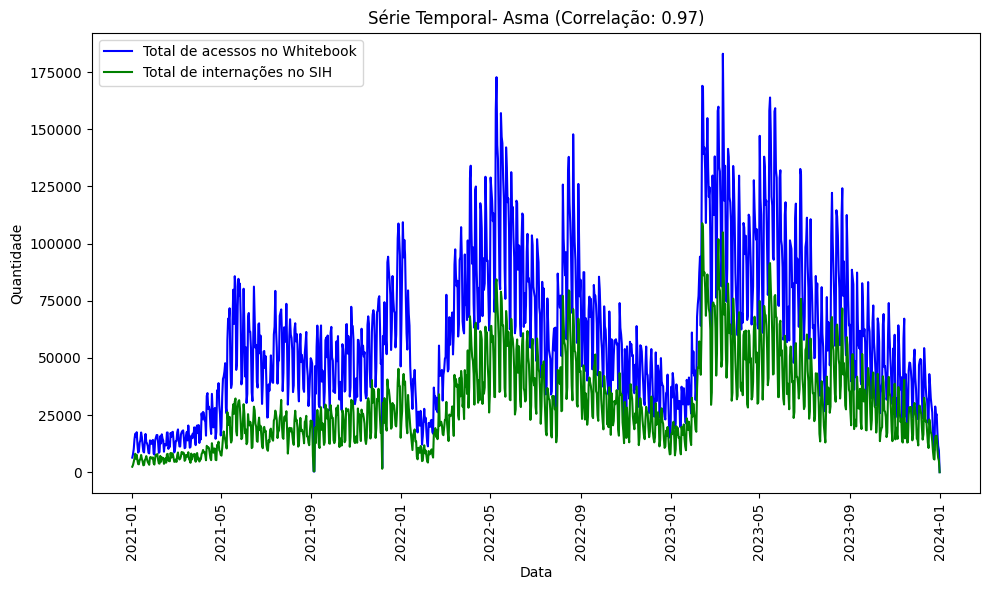

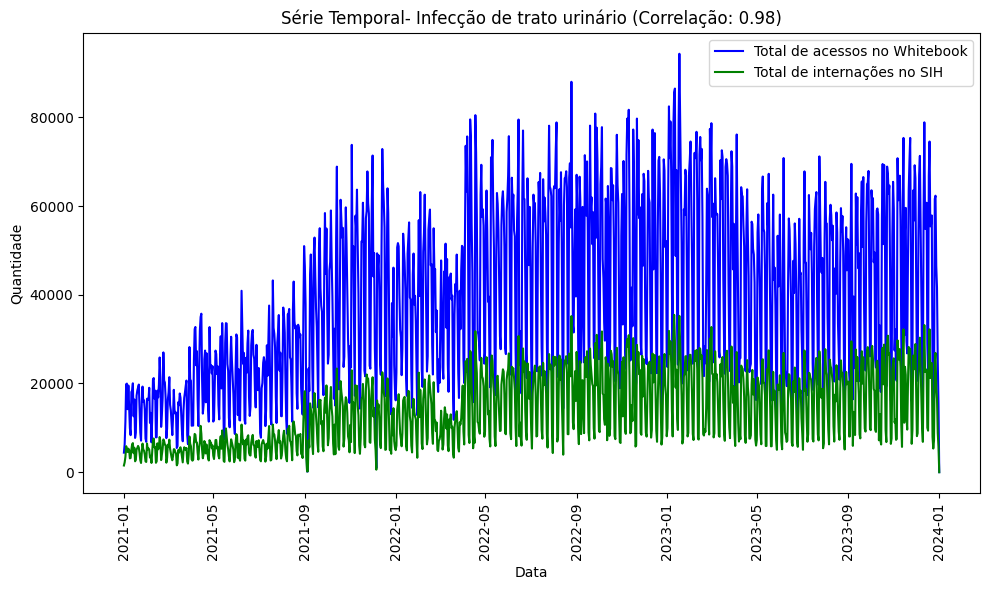

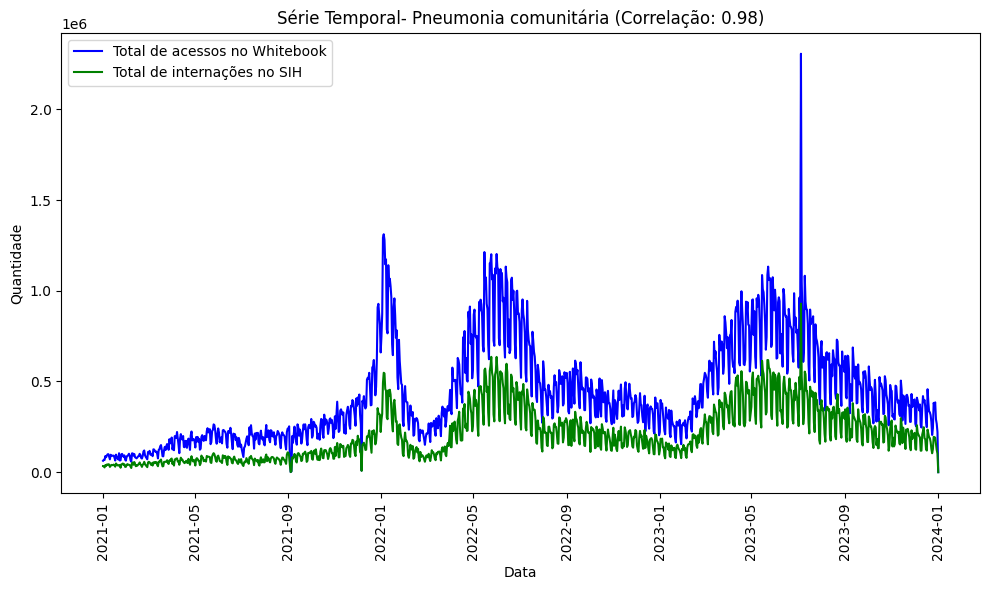

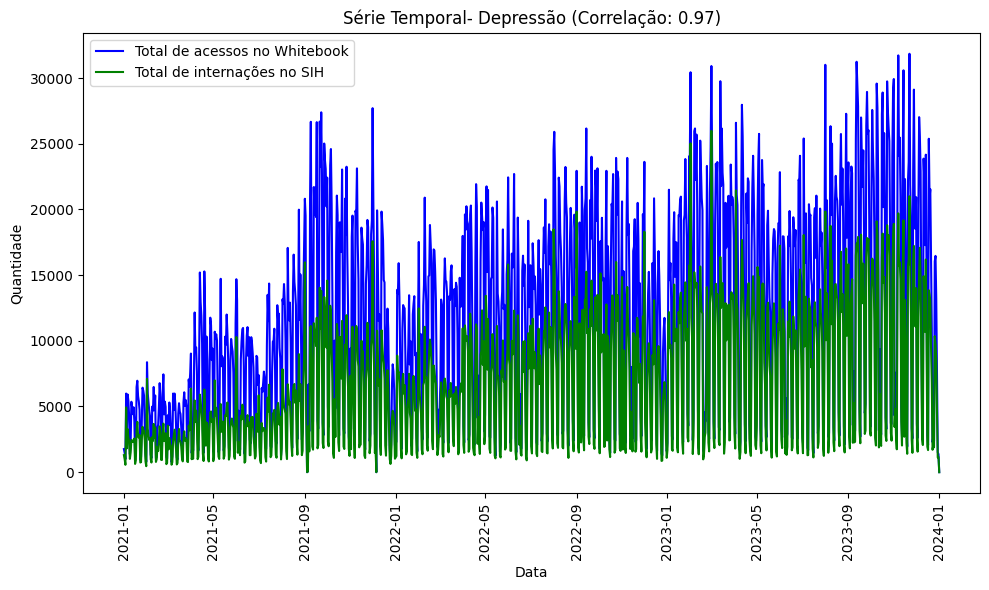

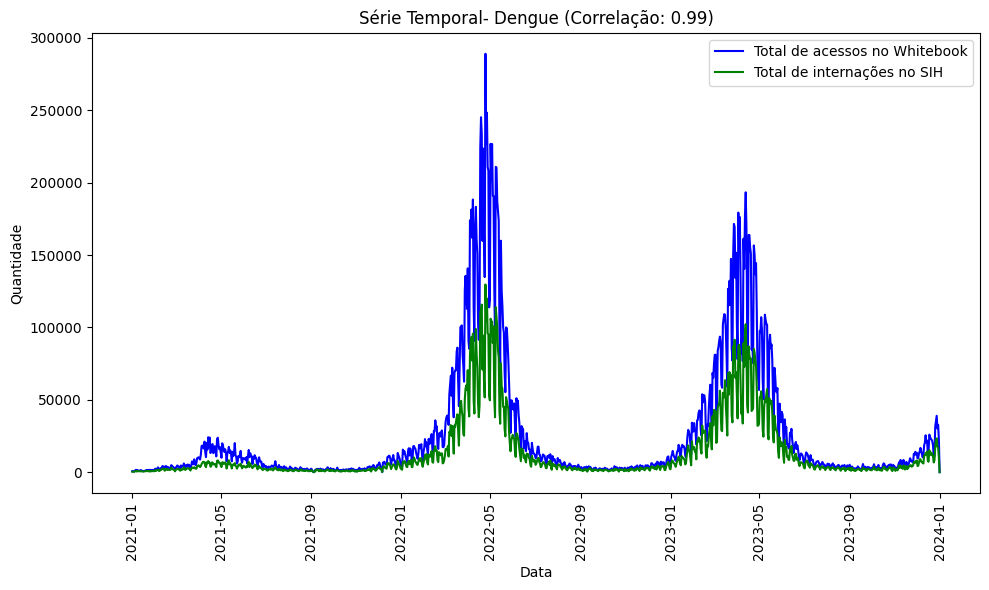

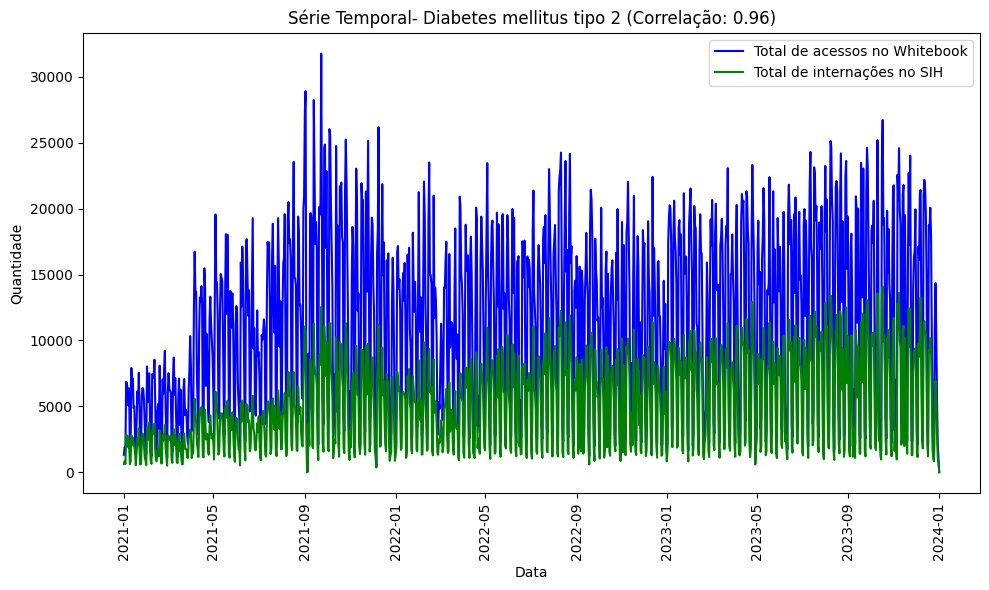

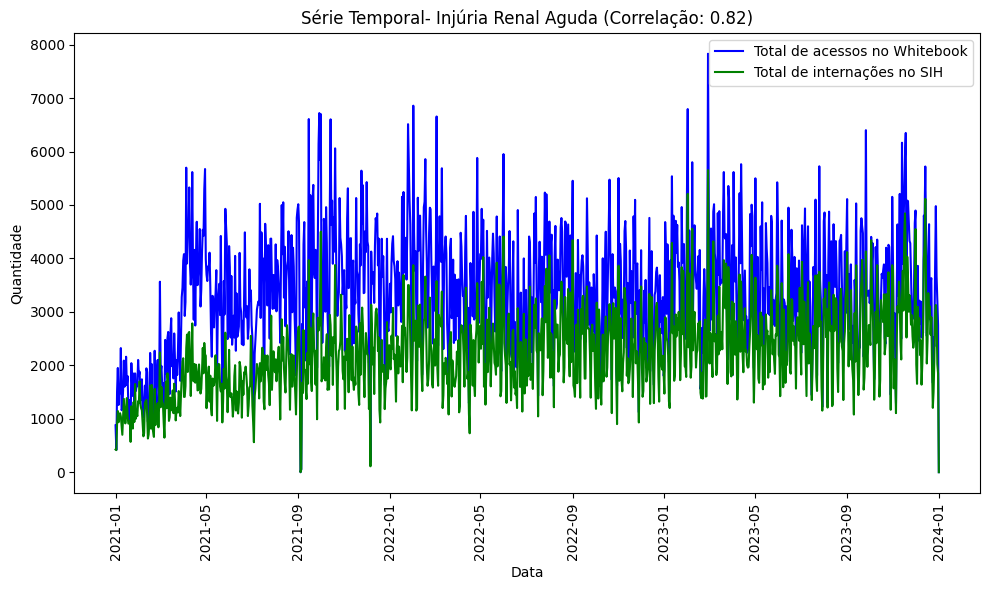

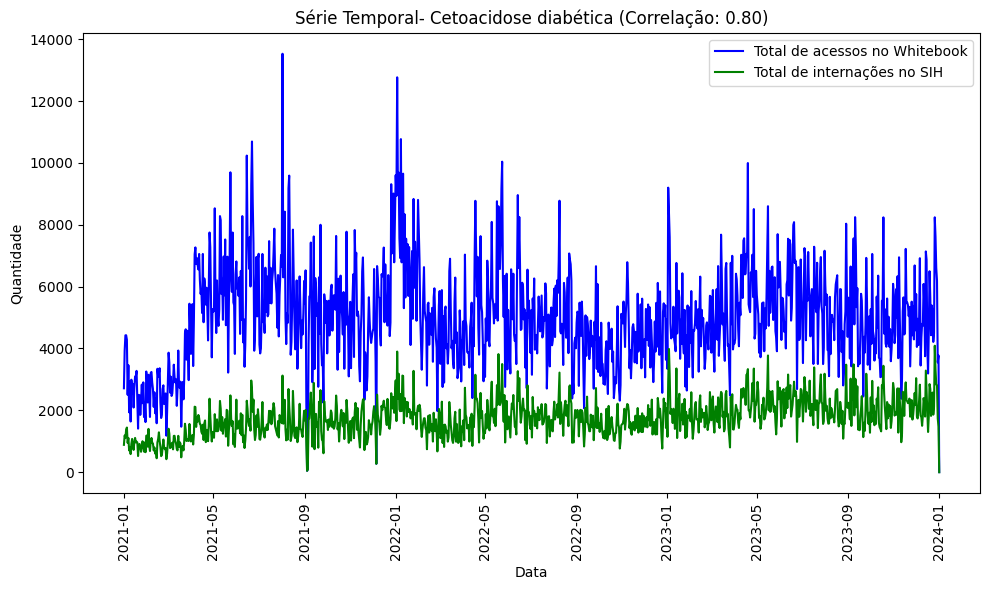

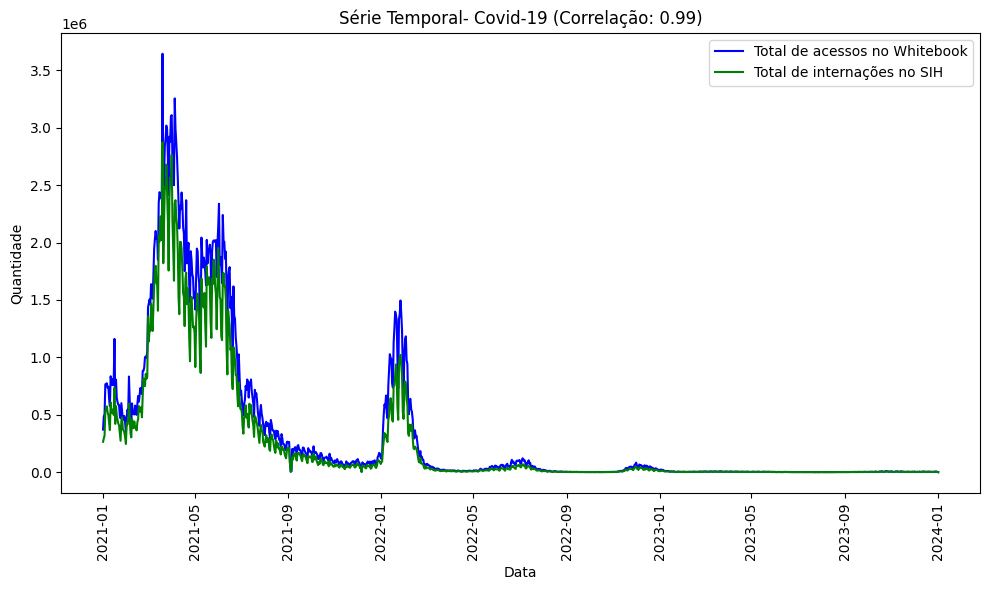

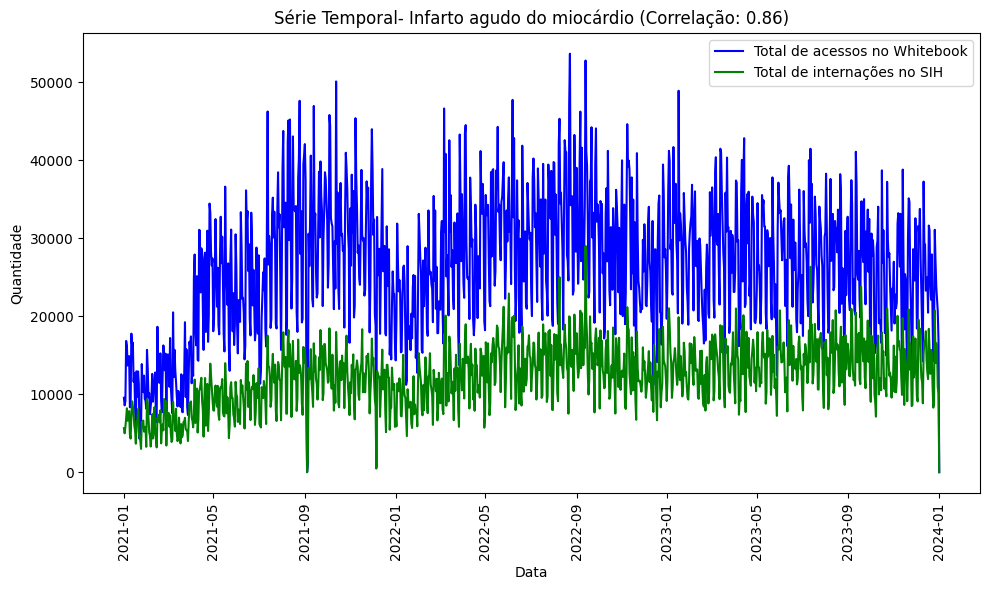

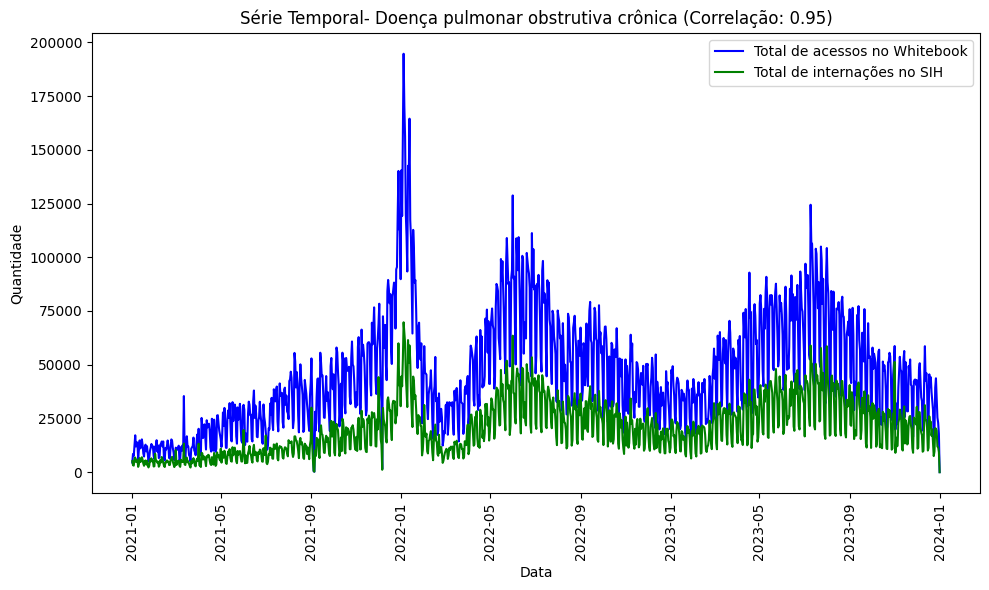

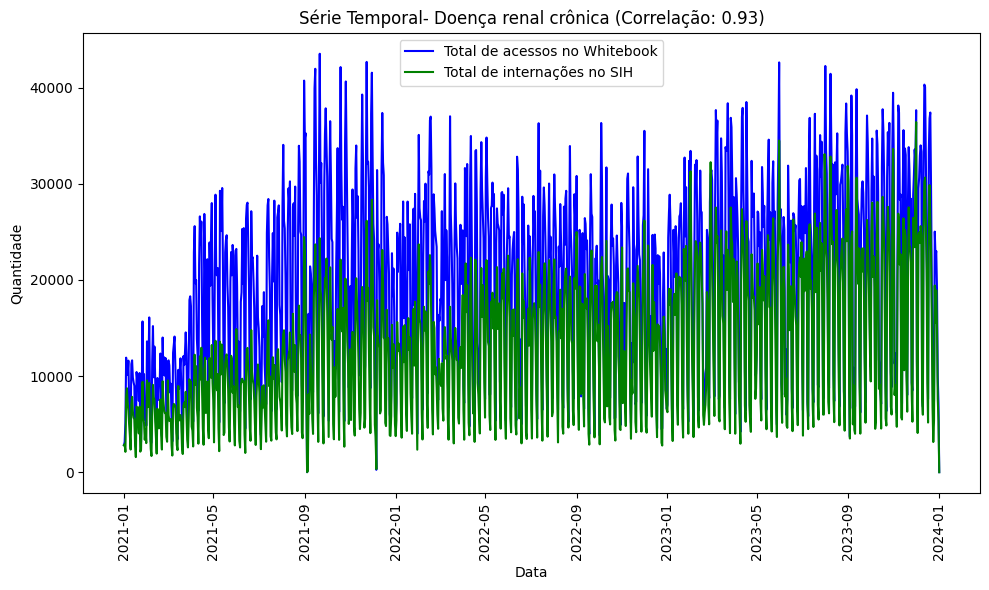

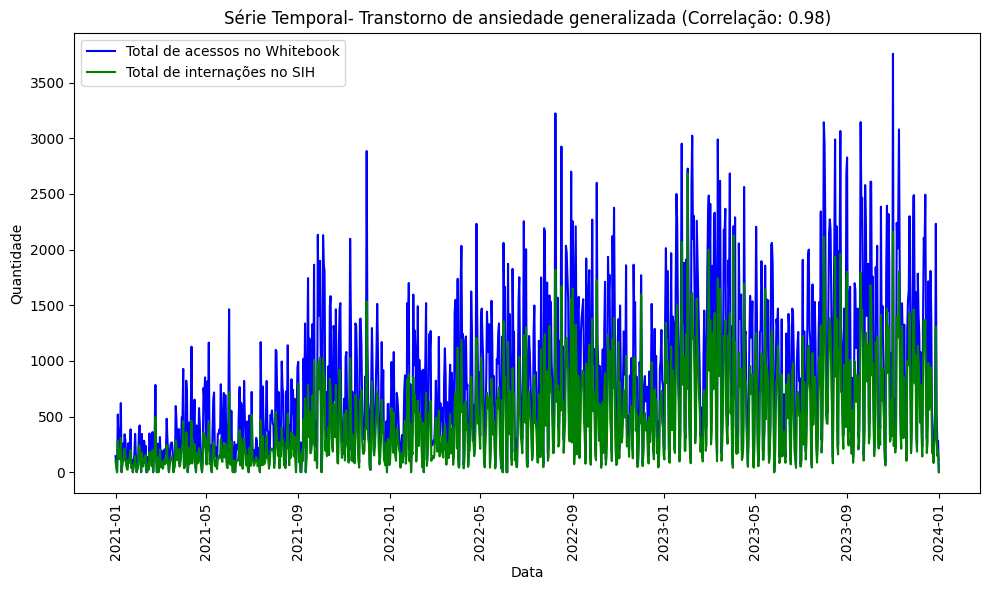

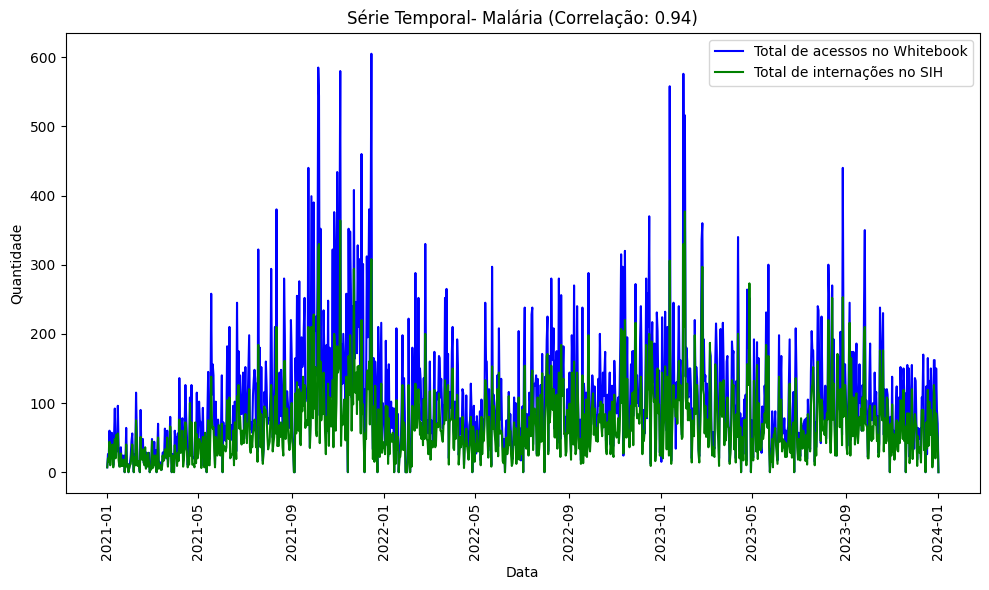

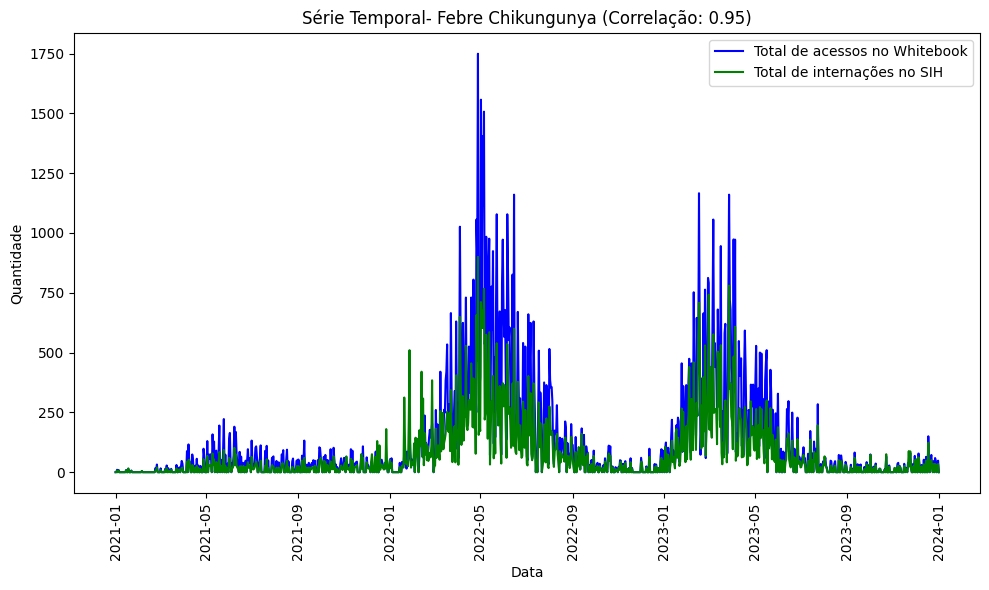

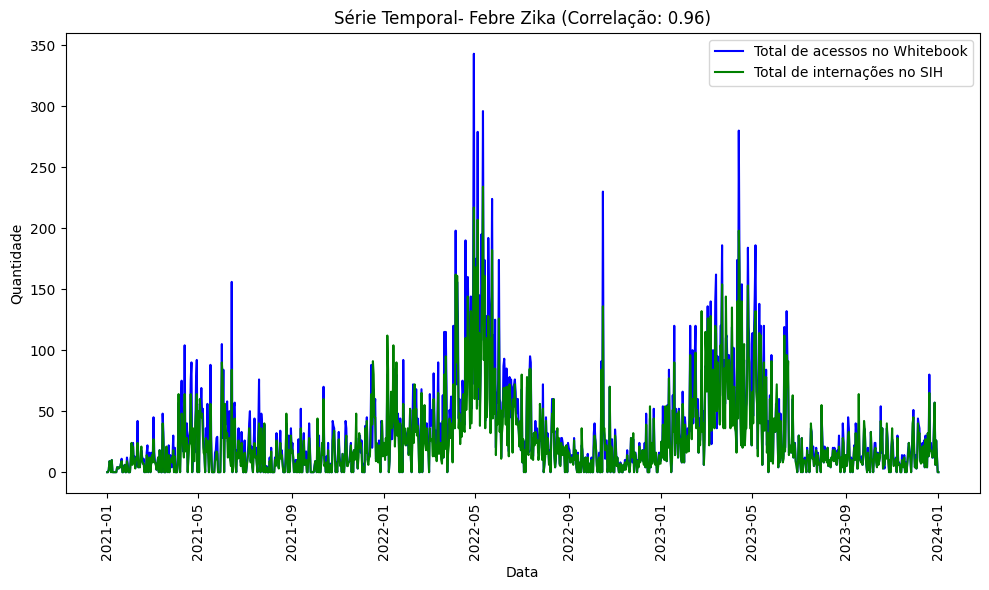

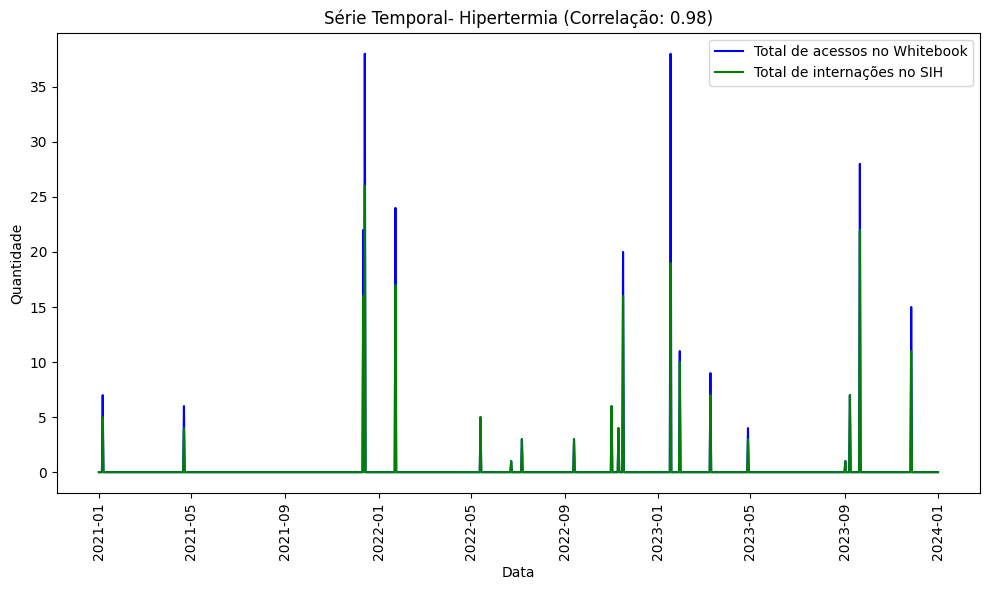

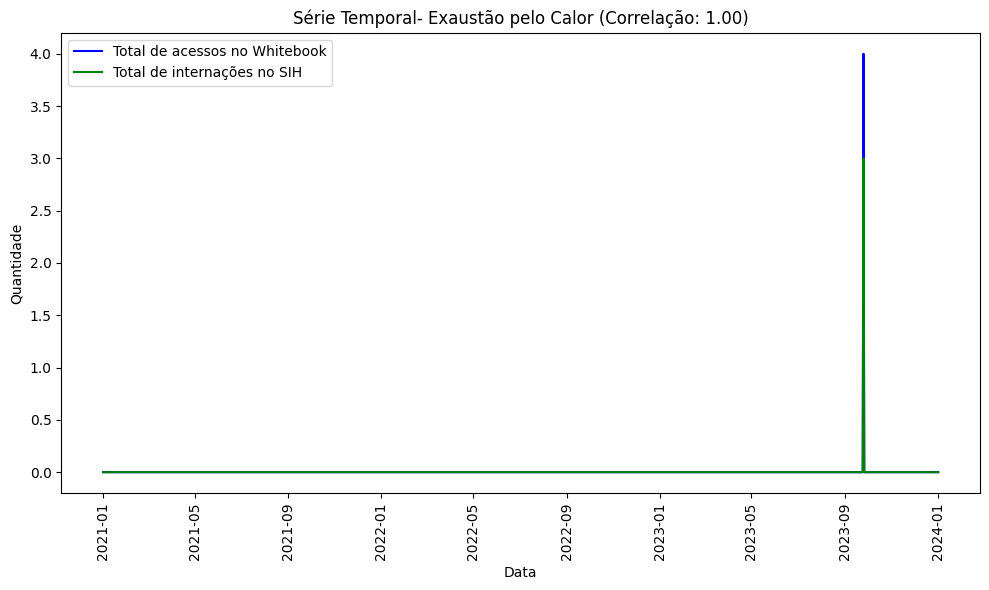

In [0]:
# Criar gráficos de linha para cada tema_principal
for tema in dados_agrupados_pandas['tema_principal'].unique():
    # Filtrar os dados para o diagnóstico atual
    dados_tema = dados_agrupados_pandas[dados_agrupados_pandas['tema_principal'] == tema].copy()

    # Ajustando range de datas
    datas_range = pd.DataFrame({
        "DT_INTER": pd.date_range(start="2021-01-01", end="2024-01-01")
    })

    # Unindo dados com datas
    dados_tema["DT_INTER"] = pd.to_datetime(dados_tema["DT_INTER"])
    dados_tema = pd.merge(datas_range, dados_tema, on="DT_INTER", how="left")

    # Substituir NaN por 0 em colunas numéricas
    num_cols = ["total_acessos", "total_internacoes", "internacoes"]
    for col in num_cols:
        if col in dados_tema.columns:  # Verificar se a coluna existe
            dados_tema[col] = dados_tema[col].fillna(0)

    # Ajustando valores não numéricos com ffill e bfill
    non_num_cols = ["unidade_federada", "CATEGORIA_PRIMARIA", "populacao"]
    for col in non_num_cols:
        if col in dados_tema.columns:  # Verificar se a coluna existe
            dados_tema[col] = dados_tema[col].ffill().bfill()
    
    # Salvando em excel
    #-- dados_tema.to_excel(f"/Workspace/Users/danielly.xavier@iclinic.com.br/resultados_modelo_ts_research_center/analise_nacional/dados_diarios/{tema}_{correlacao}_series_temporais_diario.xlsx")
    
    # Calcular a correlação entre 'total_acessos' e 'total_internacoes'
    correlacao = round(dados_tema[['internacoes', 'total_acessos']].corr().iloc[0, 1], 2)
    
    # Plotar as séries temporais
    plt.figure(figsize=(10,6))
    
    # Série temporal de 'total_acessos'
    plt.plot(dados_tema['DT_INTER'], dados_tema['total_acessos'], label='Total de acessos no Whitebook', color='blue')
    
    # Série temporal de 'total_internacoes'
    plt.plot(dados_tema['DT_INTER'], dados_tema['internacoes'], label='Total de internações no SIH', color='green')
    
    # Adicionar título e rótulos com a correlação
    plt.title(f'Série Temporal- {tema} (Correlação: {correlacao:.2f})')
    plt.xlabel('Data')
    plt.ylabel('Quantidade')
    plt.legend()
    
    # Ajuste de layout
    plt.xticks(rotation=90)
    plt.tight_layout()
    
    # Salvar o gráfico
    plt.savefig(f"/Workspace/Users/danielly.xavier@iclinic.com.br/Modelo Séries Temporais Clima e Saúde WB/Modelo Séries Temporais Clima e Saúde WB - Resultados/analise_nacional/graficos_correlacao/{tema}_{correlacao}_series_temporais.png")
    
    # Exibir o gráfico no notebook
    plt.show()

In [0]:
# Lista para acumular os resultados
resultados_correlacao = []

# Criar gráficos de linha para cada tema_principal e unidade_federada
for tema in merged_uf_df['CATEGORIA_PRIMARIA'].unique():
    for uf in merged_uf_df['unidade_federada'].unique():
        # Filtrar os dados para o diagnóstico atual
        dados_tema = merged_uf_df[
            (merged_uf_df['CATEGORIA_PRIMARIA'] == tema) & (merged_uf_df['unidade_federada'] == uf)
        ].copy()

        # Ajustando range de datas
        datas_range = pd.DataFrame({
            "DT_INTER": pd.date_range(start="2021-01-01", end="2024-05-30")
        })

        # Unindo dados com datas
        dados_tema["DT_INTER"] = pd.to_datetime(dados_tema["DT_INTER"])
        dados_tema = pd.merge(datas_range, dados_tema, on="DT_INTER", how="left")

        # Substituir NaN por 0 em colunas numéricas
        num_cols = ["INTERNACOES", "count", "taxa_internacao"]
        for col in num_cols:
            if col in dados_tema.columns:  # Verificar se a coluna existe
                dados_tema[col] = dados_tema[col].fillna(0)

        # Ajustando valores não numéricos com ffill e bfill
        non_num_cols = ["unidade_federada", "CATEGORIA_PRIMARIA", "populacao"]
        for col in non_num_cols:
            if col in dados_tema.columns:  # Verificar se a coluna existe
                dados_tema[col] = dados_tema[col].ffill().bfill()
        
        # Calcular a correlação entre 'INTERNACOES' e 'count'
        correlacao = round(dados_tema[['INTERNACOES', 'count']].corr().iloc[0, 1], 2)

        # Adicionar o resultado à lista
        resultados_correlacao.append({"uf": uf, "tema": tema, "correlacao": correlacao})

        # Salvar o DataFrame processado em Excel
        caminho_excel = f"/Workspace/Users/danielly.xavier@iclinic.com.br/Modelo Séries Temporais Clima e Saúde WB/Modelo Séries Temporais Clima e Saúde WB - Resultados/analise_estadual/dados_diarios/{uf}_{tema}_{correlacao}_series_temporais_diario.xlsx"
        #-- dados_tema.to_excel(caminho_excel, index=False)

        # Plotar as séries temporais
        plt.figure(figsize=(10, 6))
        plt.plot(dados_tema['DT_INTER'], dados_tema['count'], label='Total de acessos no Whitebook', color='blue')
        plt.plot(dados_tema['DT_INTER'], dados_tema['INTERNACOES'], label='Total de internações no SIH', color='green')

        # Adicionar título e rótulos com a correlação
        plt.title(f'Série Temporal - {tema} em {uf}, (Correlação: {correlacao:.2f})')
        plt.xlabel('Data')
        plt.ylabel('Quantidade')
        plt.legend()
        plt.xticks(rotation=90)
        plt.tight_layout()

        # Salvar o gráfico diretamente
        caminho_grafico = f"/Workspace/Users/danielly.xavier@iclinic.com.br/Modelo Séries Temporais Clima e Saúde WB/Modelo Séries Temporais Clima e Saúde WB - Resultados/analise_estadual/graficos_correlacao/{uf}_{tema}_{correlacao}_series_temporais.png"
        plt.savefig(caminho_grafico, dpi=300)

        # Fechar o gráfico para liberar memória
        plt.close()

        # Limpar o DataFrame processado
        del dados_tema

In [0]:
# Criar o DataFrame de resultados de correlação
df_resultados = pd.DataFrame(resultados_correlacao)

# Ordenar pela correlação (maior para menor)
df_resultados = df_resultados.sort_values(by="correlacao", ascending=False)

# Salvar o DataFrame final em um arquivo Excel
caminho_final = "/Workspace/Users/danielly.xavier@iclinic.com.br/Modelo Séries Temporais Clima e Saúde WB/Modelo Séries Temporais Clima e Saúde WB - Resultados/analise_estadual/graficos_correlacao/00A_resultados_correlacao.xlsx"

df_resultados.to_excel(caminho_final, index=False)

## Treinamento de modelos de Séries Temporais

### Modelos nacionais

In [0]:
# Função para dividir os dados em treino (antes de 2023) e teste (2023)
def prepare_data(df):
    # Converter '2023-01-01' para um objeto datetime compatível com datetime64[ns]
    data_limite = pd.to_datetime('2023-01-01')

    # Como 'DT_INTER' virou índice, usamos o índice para a filtragem
    treino = df[df.index < data_limite]
    teste = df[df.index >= data_limite]
    
    return treino, teste

In [0]:
def prepare_time_series_data(df, tema):
    # Filtrar o tema principal específico
    dados_tema = df[df['tema_principal'] == tema].copy()

    # Selecionar as colunas necessárias
    dados_tema = dados_tema[['DT_INTER', 'internacoes', 'total_acessos']]

    # Garantir que DT_INTER seja tratado como data
    dados_tema['DT_INTER'] = pd.to_datetime(dados_tema['DT_INTER'])

    # Definir DT_INTER como índice
    dados_tema.set_index('DT_INTER', inplace=True)

    # Verificar o intervalo completo de datas desde o início até o fim
    all_dates = pd.date_range(start=dados_tema.index.min(), end=dados_tema.index.max())

    # Adicionar as datas faltantes e preencher com NaN
    dados_tema = dados_tema.reindex(all_dates, fill_value=pd.NA)

    # Interpolar os dados para preencher os valores NaN
    dados_tema.interpolate(method='time', inplace=True)

    # Remover as lacunas com mais de 3 dias consecutivos sem dados
    # Criar uma série booleana que identifica onde estão os NaNs
    is_nan = dados_tema['internacoes'].isna() | dados_tema['total_acessos'].isna()

    # Agrupar os NaNs e contar os grupos consecutivos
    grouped_nan = is_nan.groupby((is_nan != is_nan.shift()).cumsum()).cumsum()

    # Encontrar os índices onde a contagem de NaNs consecutivos é maior que 3
    to_remove = grouped_nan[grouped_nan > 3].index

    # Remover esses índices do DataFrame
    dados_tema.drop(index=to_remove, inplace=True)

    return dados_tema

#### Modelo Univariado

In [0]:
# Função para treinar o modelo SARIMAX com ou sem variável exógena
def treinar_modelo_sarimax_univariado(treino, teste):
    # Separar a variável dependente (internacoes)
    y_train = treino['internacoes']
    y_test = teste['internacoes']
    
    # Criar e ajustar o modelo SARIMAX (com ou sem variável exógena)
    modelo = SARIMAX(y_train, exog=None, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    resultado = modelo.fit(disp=False)
    
    # Fazer previsões para o período de teste
    forecast = resultado.get_forecast(steps=len(teste))
    
    # Gerar o intervalo de confiança
    conf_int = forecast.conf_int(alpha=0.05)
    
    return resultado, forecast, conf_int

In [0]:
# Função para plotar as previsões e dados reais
def plot_forecast_univariado(treino, teste, forecast, conf_int, tema):
    plt.figure(figsize=(10,6))
    
    # Plotar os dados de treino
    plt.plot(treino.index, treino['internacoes'], label='Treino (Observado)', color='blue')
    
    # Plotar os dados de teste
    plt.plot(teste.index, teste['internacoes'], label='Teste (Observado)', color='orange')
    
    # Plotar o forecast
    plt.plot(teste.index, forecast.predicted_mean, label='Forecast (Predição)', color='green')
    
    # Plotar intervalo de confiança
    plt.fill_between(teste.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='gray', alpha=0.3, label='95% Intervalo de Confiança')
    
    # Configurações do gráfico
    plt.title(f'Forecast SARIMAX univariado - {tema}')
    plt.xlabel('Data')
    plt.ylabel('Total Internações')
    plt.xticks(rotation=90)
    plt.legend()
    plt.tight_layout()
    
    # Salvar o gráfico com o prefixo "ts_", tema e tipo de modelo
    plt.savefig(f"/Workspace/Users/danielly.xavier@iclinic.com.br/Modelo Séries Temporais Clima e Saúde WB/Modelo Séries Temporais Clima e Saúde WB - Resultados/analise_nacional/ts_univariada/graficos/00B_ts_{tema}_univariado_forecast_nacional.png")
    plt.close()

In [0]:
# Função para gerar e salvar o sumário do modelo em Excel
def summary_modelo_univariado(resultado, tema):
    print(f'Summary do modelo SARIMAX univariado para {tema}')
    print(resultado.summary())
    
    # Converte o summary em uma string e divide em linhas
    summary_text = resultado.summary().as_text().splitlines()
    
    # Converte cada linha do summary em uma lista de strings para formar um DataFrame
    summary_df = pd.DataFrame([line.split() for line in summary_text if line.strip()], dtype=str)
    
    # Define o caminho do arquivo de saída
    output_path = f"/Workspace/Users/danielly.xavier@iclinic.com.br/Modelo Séries Temporais Clima e Saúde WB/Modelo Séries Temporais Clima e Saúde WB - Resultados/analise_nacional/ts_univariada/summaries/00B_ts_{tema}_univariado_summary.xlsx"
    
    # Salva o DataFrame no Excel
    summary_df.to_excel(output_path, index=False, header=False)
    
    print(f"Summary completo salvo em: {output_path}")

In [0]:
# Loop para cada tema principal
for tema in dados_agrupados_pandas['tema_principal'].unique():
    try:
        # Preparar os dados de série temporal
        dados_tema = prepare_time_series_data(dados_agrupados_pandas, tema)
        
        # Dividir em treino (anos antes de 2023) e teste (2023)
        treino, teste = prepare_data(dados_tema)
        
        # Treinar e salvar o modelo univariado (sem exógena)
        resultado_uni, forecast_uni, conf_int_uni = treinar_modelo_sarimax_univariado(treino, teste)
        plot_forecast_univariado(treino, teste, forecast_uni, conf_int_uni, tema)
        summary_modelo_univariado(resultado_uni, tema)
            
    except ValueError as ve:
        # Se ocorrer um ValueError (como o array vazio), imprimir a mensagem de erro
        print(f"Erro ao processar o tema '{tema}': {ve}")
    
    except Exception as e:
        # Capturar outros tipos de exceções e imprimir a mensagem de erro
        print(f"Ocorreu um erro inesperado ao processar o tema '{tema}': {e}")

/databricks/python/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX univariado para Asma
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -7500.368
Date:                            Thu, 06 Feb 2025   AIC                          15010.736
Time:                                    16:46:16   BIC                          15033.612
Sample:                                01-01-2021   HQIC                         15019.569
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4581      0.044     10.348      0.000       0.371 

/databricks/python/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX univariado para Infecção de trato urinário
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -7173.747
Date:                            Thu, 06 Feb 2025   AIC                          14357.494
Time:                                    16:46:35   BIC                          14380.369
Sample:                                01-01-2021   HQIC                         14366.327
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4486      0.033     13.655  

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX univariado para Pneumonia comunitária
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -8977.489
Date:                            Thu, 06 Feb 2025   AIC                          17964.979
Time:                                    16:46:50   BIC                          17987.854
Sample:                                01-01-2021   HQIC                         17973.812
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4548      0.134      3.406      0

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX univariado para Depressão
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -6836.755
Date:                            Thu, 06 Feb 2025   AIC                          13683.509
Time:                                    16:47:07   BIC                          13706.385
Sample:                                01-01-2021   HQIC                         13692.342
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4589      0.033     13.848      0.000       0

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX univariado para Dengue
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -7419.212
Date:                            Thu, 06 Feb 2025   AIC                          14848.425
Time:                                    16:47:26   BIC                          14871.300
Sample:                                01-01-2021   HQIC                         14857.258
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4001      0.026     15.336      0.000       0.34

/databricks/python/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX univariado para Diabetes mellitus tipo 2
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -6625.536
Date:                            Thu, 06 Feb 2025   AIC                          13261.072
Time:                                    16:47:45   BIC                          13283.947
Sample:                                01-01-2021   HQIC                         13269.905
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4367      0.037     11.769    

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX univariado para Injúria Renal Aguda
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -5634.198
Date:                            Thu, 06 Feb 2025   AIC                          11278.396
Time:                                    16:48:04   BIC                          11301.271
Sample:                                01-01-2021   HQIC                         11287.229
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3087      0.032      9.752      0.0

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX univariado para Cetoacidose diabética
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -5429.053
Date:                            Thu, 06 Feb 2025   AIC                          10868.106
Time:                                    16:48:19   BIC                          10890.981
Sample:                                01-01-2021   HQIC                         10876.939
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1971      0.039      5.017      0

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX univariado para Covid-19
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -9531.679
Date:                            Thu, 06 Feb 2025   AIC                          19073.359
Time:                                    16:48:31   BIC                          19096.234
Sample:                                01-01-2021   HQIC                         19082.192
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3621      0.113      3.215      0.001       0.

/databricks/python/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX univariado para Infarto agudo do miocárdio
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -6779.621
Date:                            Thu, 06 Feb 2025   AIC                          13569.241
Time:                                    16:48:48   BIC                          13592.117
Sample:                                01-01-2021   HQIC                         13578.074
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2313      0.039      5.862  

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX univariado para Doença pulmonar obstrutiva crônica
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -7340.315
Date:                            Thu, 06 Feb 2025   AIC                          14690.629
Time:                                    16:49:05   BIC                          14713.505
Sample:                                01-01-2021   HQIC                         14699.462
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3948      0.042     

/databricks/python/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX univariado para Doença renal crônica
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -7122.392
Date:                            Thu, 06 Feb 2025   AIC                          14254.784
Time:                                    16:49:25   BIC                          14277.660
Sample:                                01-01-2021   HQIC                         14263.617
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4829      0.035     13.866      0.

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX univariado para Transtorno de ansiedade generalizada
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -5072.010
Date:                            Thu, 06 Feb 2025   AIC                          10154.020
Time:                                    16:49:42   BIC                          10176.896
Sample:                                01-01-2021   HQIC                         10162.853
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2656      0.033   

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX univariado para Malária
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -3740.056
Date:                            Thu, 06 Feb 2025   AIC                           7490.111
Time:                                    16:49:57   BIC                           7512.986
Sample:                                01-01-2021   HQIC                          7498.944
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0765      0.031      2.487      0.013       0.0

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX univariado para Febre Chikungunya
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  728
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -4160.925
Date:                            Thu, 06 Feb 2025   AIC                           8331.850
Time:                                    16:50:13   BIC                           8354.712
Sample:                                01-03-2021   HQIC                          8340.679
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0554      0.023      2.372      0.018

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX univariado para Febre Zika
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  728
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -3256.715
Date:                            Thu, 06 Feb 2025   AIC                           6523.430
Time:                                    16:50:26   BIC                           6546.291
Sample:                                01-03-2021   HQIC                          6532.258
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1008      0.031      3.203      0.001       

/databricks/python/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX univariado para Hipertermia
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  725
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 -12.519
Date:                            Thu, 06 Feb 2025   AIC                             35.039
Time:                                    16:50:44   BIC                             57.879
Sample:                                01-06-2021   HQIC                            43.861
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0898      0.038      2.333      0.020      

/databricks/python/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/databricks/python/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/databricks/python/lib/python3.11/site-packages/statsmodels/base/model.py:534: RuntimeWarning: invalid value encountered in double_scalars
  return -self.loglike(params, *args) / nobs


Ocorreu um erro inesperado ao processar o tema 'Exaustão pelo Calor': Schur decomposition solver error.


#### Modelo com variável exógena (Whitebook)

In [0]:
# Função para treinar o modelo SARIMAX com ou sem variável exógena
def treinar_modelo_sarimax_exogena(treino, teste, com_exog=True):
    # Separar a variável dependente (internacoes)
    y_train = treino['internacoes']
    y_test = teste['internacoes']
    
    exog_train = treino[['total_acessos']]
    exog_test = teste[['total_acessos']]
   
    # Criar e ajustar o modelo SARIMAX (com ou sem variável exógena)
    modelo = SARIMAX(y_train, exog=exog_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    resultado = modelo.fit(disp=False)
    
    # Fazer previsões para o período de teste
    forecast = resultado.get_forecast(steps=len(teste), exog=exog_test)
    
    # Gerar o intervalo de confiança
    conf_int = forecast.conf_int(alpha=0.05)
    
    return resultado, forecast, conf_int

In [0]:
# Função para plotar as previsões e dados reais
def plot_forecast_exogena(treino, teste, forecast, conf_int, tema):
    plt.figure(figsize=(10,6))
    
    # Plotar os dados de treino
    plt.plot(treino.index, treino['internacoes'], label='Treino (Observado)', color='blue')
    
    # Plotar os dados de teste
    plt.plot(teste.index, teste['internacoes'], label='Teste (Observado)', color='orange')
    
    # Plotar o forecast
    plt.plot(teste.index, forecast.predicted_mean, label='Forecast (Predição)', color='green')
    
    # Plotar intervalo de confiança
    plt.fill_between(teste.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='gray', alpha=0.3, label='95% Intervalo de Confiança')
    
    # Configurações do gráfico
    plt.title(f'Forecast SARIMAX com variável exógena - {tema}')
    plt.xlabel('Data')
    plt.ylabel('Total Internações')
    plt.xticks(rotation=90)
    plt.legend()
    plt.tight_layout()
    
    # Salvar o gráfico com o prefixo "ts_", tema e tipo de modelo
    plt.savefig(f"/Workspace/Users/danielly.xavier@iclinic.com.br/Modelo Séries Temporais Clima e Saúde WB/Modelo Séries Temporais Clima e Saúde WB - Resultados/analise_nacional/ts_exogena/graficos/00B_ts_{tema}_exogena_forecast_nacional.png")
    plt.close()

In [0]:
# Função para gerar e salvar o sumário do modelo em Excel
def summary_modelo_exogena(resultado, tema):
    print(f'Summary do modelo SARIMAX com variável exógena para {tema}')
    print(resultado.summary())
    
    # Converte o summary em uma string e divide em linhas
    summary_text = resultado.summary().as_text().splitlines()
    
    # Converte cada linha do summary em uma lista de strings para formar um DataFrame
    summary_df = pd.DataFrame([line.split() for line in summary_text if line.strip()], dtype=str)
    
    # Define o caminho do arquivo de saída
    output_path = f"/Workspace/Users/danielly.xavier@iclinic.com.br/Modelo Séries Temporais Clima e Saúde WB/Modelo Séries Temporais Clima e Saúde WB - Resultados/analise_nacional/ts_exogena/summaries/00B_ts_{tema}_exaogena_summary.xlsx"
    
    # Salva o DataFrame no Excel
    summary_df.to_excel(output_path, index=False, header=False)
    
    print(f"Summary completo salvo em: {output_path}")

In [0]:
# Loop para cada tema principal
for tema in dados_agrupados_pandas['tema_principal'].unique():
    try:
        # Preparar os dados de série temporal
        dados_tema = prepare_time_series_data(dados_agrupados_pandas, tema)
        
        # Dividir em treino (anos antes de 2023) e teste (2023)
        treino, teste = prepare_data(dados_tema)
                
        # Treinar e salvar o modelo com exógena
        resultado_exog, forecast_exog, conf_int_exog = treinar_modelo_sarimax_exogena(treino, teste)
        plot_forecast_exogena(treino, teste, forecast_exog, conf_int_exog, tema)
        summary_modelo_exogena(resultado_exog, tema)
    
    except ValueError as ve:
        # Se ocorrer um ValueError (como o array vazio), imprimir a mensagem de erro
        print(f"Erro ao processar o tema '{tema}': {ve}")
    
    except Exception as e:
        # Capturar outros tipos de exceções e imprimir a mensagem de erro
        print(f"Ocorreu um erro inesperado ao processar o tema '{tema}': {e}")

/databricks/python/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX com variável exógena para Asma
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -6809.746
Date:                            Thu, 06 Feb 2025   AIC                          13631.492
Time:                                    16:51:09   BIC                          13658.943
Sample:                                01-01-2021   HQIC                         13642.092
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
total_acessos     0.5109      0.006     86.703     

/databricks/python/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX com variável exógena para Infecção de trato urinário
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -6163.931
Date:                            Thu, 06 Feb 2025   AIC                          12339.862
Time:                                    16:51:28   BIC                          12367.313
Sample:                                01-01-2021   HQIC                         12350.462
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
total_acessos     0.3635     

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX com variável exógena para Pneumonia comunitária
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -8107.734
Date:                            Thu, 06 Feb 2025   AIC                          16227.467
Time:                                    16:51:42   BIC                          16254.918
Sample:                                01-01-2021   HQIC                         16238.067
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
total_acessos     0.5245      0.01

/databricks/python/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX com variável exógena para Depressão
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -5944.586
Date:                            Thu, 06 Feb 2025   AIC                          11901.173
Time:                                    16:52:13   BIC                          11928.623
Sample:                                01-01-2021   HQIC                         11911.772
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
total_acessos     0.5371      0.006     84.644

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX com variável exógena para Dengue
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -6477.177
Date:                            Thu, 06 Feb 2025   AIC                          12966.354
Time:                                    16:52:27   BIC                          12993.804
Sample:                                01-01-2021   HQIC                         12976.953
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
total_acessos     0.5322      0.003    171.723   

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX com variável exógena para Diabetes mellitus tipo 2
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -5574.712
Date:                            Thu, 06 Feb 2025   AIC                          11161.424
Time:                                    16:52:43   BIC                          11188.875
Sample:                                01-01-2021   HQIC                         11172.024
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
total_acessos     0.4234      0

/databricks/python/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX com variável exógena para Injúria Renal Aguda
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -5208.018
Date:                            Thu, 06 Feb 2025   AIC                          10428.036
Time:                                    16:53:00   BIC                          10455.487
Sample:                                01-01-2021   HQIC                         10438.636
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
total_acessos     0.5145      0.012 

/databricks/python/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX com variável exógena para Cetoacidose diabética
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -4930.652
Date:                            Thu, 06 Feb 2025   AIC                           9873.304
Time:                                    16:53:19   BIC                           9900.754
Sample:                                01-01-2021   HQIC                          9883.903
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
total_acessos     0.2880      0.00

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX com variável exógena para Covid-19
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -8987.677
Date:                            Thu, 06 Feb 2025   AIC                          17987.353
Time:                                    16:53:32   BIC                          18014.804
Sample:                                01-01-2021   HQIC                         17997.953
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
total_acessos     0.8125      0.018     44.892 

/databricks/python/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX com variável exógena para Infarto agudo do miocárdio
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -6336.868
Date:                            Thu, 06 Feb 2025   AIC                          12685.736
Time:                                    16:53:49   BIC                          12713.186
Sample:                                01-01-2021   HQIC                         12696.335
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
total_acessos     0.3583     

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX com variável exógena para Doença pulmonar obstrutiva crônica
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -6625.078
Date:                            Thu, 06 Feb 2025   AIC                          13262.156
Time:                                    16:54:06   BIC                          13289.606
Sample:                                01-01-2021   HQIC                         13272.755
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
total_acessos     0.4

/databricks/python/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX com variável exógena para Doença renal crônica
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -6395.895
Date:                            Thu, 06 Feb 2025   AIC                          12803.791
Time:                                    16:54:25   BIC                          12831.241
Sample:                                01-01-2021   HQIC                         12814.390
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
total_acessos     0.5712      0.008

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX com variável exógena para Transtorno de ansiedade generalizada
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -4035.826
Date:                            Thu, 06 Feb 2025   AIC                           8083.652
Time:                                    16:54:43   BIC                           8111.103
Sample:                                01-01-2021   HQIC                          8094.252
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
total_acessos     0

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX com variável exógena para Malária
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -3021.157
Date:                            Thu, 06 Feb 2025   AIC                           6054.315
Time:                                    16:54:59   BIC                           6081.765
Sample:                                01-01-2021   HQIC                          6064.914
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
total_acessos     0.5400      0.006     95.391  

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX com variável exógena para Febre Chikungunya
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  728
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -3600.167
Date:                            Thu, 06 Feb 2025   AIC                           7212.335
Time:                                    16:55:15   BIC                           7239.768
Sample:                                01-03-2021   HQIC                          7222.929
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
total_acessos     0.5073      0.006   

/databricks/python/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX com variável exógena para Febre Zika
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  728
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -2607.712
Date:                            Thu, 06 Feb 2025   AIC                           5227.423
Time:                                    16:55:32   BIC                           5254.857
Sample:                                01-03-2021   HQIC                          5238.017
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
total_acessos     0.7232      0.005    135.70

/databricks/python/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX com variável exógena para Hipertermia
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  725
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                1679.419
Date:                            Thu, 06 Feb 2025   AIC                          -3346.837
Time:                                    16:55:49   BIC                          -3319.429
Sample:                                01-06-2021   HQIC                         -3336.251
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
total_acessos     0.6412      0.000   1867.8

### Modelos estaduais

In [0]:
def prepare_time_series_data_uf(df, tema, uf):
    # Filtrar o tema principal específico
    dados_tema = df[(df['tema_principal'] == tema) & (df['UF'] == uf)].copy()

    # Selecionar as colunas necessárias
    dados_tema = dados_tema[['DT_INTER', 'internacoes', 'total_acessos']]

    # Garantir que DT_INTER seja tratado como data
    dados_tema['DT_INTER'] = pd.to_datetime(dados_tema['DT_INTER'])

    # Definir DT_INTER como índice
    dados_tema.set_index('DT_INTER', inplace=True)

    # Verificar o intervalo completo de datas desde o início até o fim
    all_dates = pd.date_range(start=dados_tema.index.min(), end=dados_tema.index.max())

    # Adicionar as datas faltantes e preencher com NaN
    dados_tema = dados_tema.reindex(all_dates, fill_value=pd.NA)

    # Interpolar os dados para preencher os valores NaN
    dados_tema.interpolate(method='time', inplace=True)

    # Remover as lacunas com mais de 3 dias consecutivos sem dados
    # Criar uma série booleana que identifica onde estão os NaNs
    is_nan = dados_tema['internacoes'].isna() | dados_tema['total_acessos'].isna()

    # Agrupar os NaNs e contar os grupos consecutivos
    grouped_nan = is_nan.groupby((is_nan != is_nan.shift()).cumsum()).cumsum()

    # Encontrar os índices onde a contagem de NaNs consecutivos é maior que 3
    to_remove = grouped_nan[grouped_nan > 3].index

    # Remover esses índices do DataFrame
    dados_tema.drop(index=to_remove, inplace=True)

    return dados_tema

#### Modelo Univariado

In [0]:
# Ajustando nome das colunas
dados_agrupados_pandas_uf = merged_uf_df.copy()
dados_agrupados_pandas_uf.columns = ("DT_INTER", "UF", "tema_principal", "internacoes", "total_acessos", "populacao", "taxa_internacao")

In [0]:
# Função para treinar o modelo SARIMAX com ou sem variável exógena
def treinar_modelo_sarimax_univariado_uf(treino, teste):
    # Separar a variável dependente (internacoes)
    y_train = treino['internacoes']
    y_test = teste['internacoes']
    
    # Criar e ajustar o modelo SARIMAX (com ou sem variável exógena)
    modelo = SARIMAX(y_train, exog=None, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    resultado = modelo.fit(disp=False)
    
    # Fazer previsões para o período de teste
    forecast = resultado.get_forecast(steps=len(teste))
    
    # Gerar o intervalo de confiança
    conf_int = forecast.conf_int(alpha=0.05)
    
    return resultado, forecast, conf_int

In [0]:
# Função para plotar as previsões e dados reais
def plot_forecast_univariado_uf(treino, teste, forecast, conf_int, tema):
    plt.figure(figsize=(10,6))
    
    # Plotar os dados de treino
    plt.plot(treino.index, treino['internacoes'], label='Treino (Observado)', color='blue')
    
    # Plotar os dados de teste
    plt.plot(teste.index, teste['internacoes'], label='Teste (Observado)', color='orange')
    
    # Plotar o forecast
    plt.plot(teste.index, forecast.predicted_mean, label='Forecast (Predição)', color='green')
    
    # Plotar intervalo de confiança
    plt.fill_between(teste.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='gray', alpha=0.3, label='95% Intervalo de Confiança')
    
    # Configurações do gráfico
    plt.title(f'Forecast SARIMAX univariado - {tema} em {uf}')
    plt.xlabel('Data')
    plt.ylabel('Total Internações')
    plt.xticks(rotation=90)
    plt.legend()
    plt.tight_layout()
    
    # Salvar o gráfico com o prefixo "ts_", tema e tipo de modelo
    plt.savefig(f"/Workspace/Users/danielly.xavier@iclinic.com.br/Modelo Séries Temporais Clima e Saúde WB/Modelo Séries Temporais Clima e Saúde WB - Resultados/analise_estadual/ts_univariada/graficos/00C_ts_{tema}_{uf}_univariado_forecast.png")
    plt.close()

In [0]:
# Função para gerar e salvar o sumário do modelo em Excel
def summary_modelo_univariado_uf(resultado, tema):
    print(f'Summary do modelo SARIMAX univariado para {tema}')
    print(resultado.summary())
    
    # Converte o summary em uma string e divide em linhas
    summary_text = resultado.summary().as_text().splitlines()
    
    # Converte cada linha do summary em uma lista de strings para formar um DataFrame
    summary_df = pd.DataFrame([line.split() for line in summary_text if line.strip()], dtype=str)
    
    # Define o caminho do arquivo de saída
    output_path = f"/Workspace/Users/danielly.xavier@iclinic.com.br/Modelo Séries Temporais Clima e Saúde WB/Modelo Séries Temporais Clima e Saúde WB - Resultados/analise_estadual/ts_univariada/summaries/00C_ts_{tema}_{uf}_univariado.xlsx"
    
    # Salva o DataFrame no Excel
    summary_df.to_excel(output_path, index=False, header=False)
    
    print(f"Summary completo salvo em: {output_path}")

In [0]:
# Loop para cada tema principal
for tema in dados_agrupados_pandas_uf['tema_principal'].unique():
    for uf in dados_agrupados_pandas_uf['UF'].unique():
        try:
            # Preparar os dados de série temporal
            dados_tema = prepare_time_series_data_uf(dados_agrupados_pandas_uf, tema, uf)
            
            # Dividir em treino (anos antes de 2023) e teste (2023)
            treino, teste = prepare_data(dados_tema)
            
            # Treinar e salvar o modelo univariado (sem exógena)
            resultado_uni, forecast_uni, conf_int_uni = treinar_modelo_sarimax_univariado_uf(treino, teste)
            plot_forecast_univariado_uf(treino, teste, forecast_uni, conf_int_uni, tema)
            summary_modelo_univariado_uf(resultado_uni, tema)
                
        except ValueError as ve:
            # Se ocorrer um ValueError (como o array vazio), imprimir a mensagem de erro
            print(f"Erro ao processar o tema '{tema}' na {uf}: {ve}")
        
        except Exception as e:
            # Capturar outros tipos de exceções e imprimir a mensagem de erro
            print(f"Ocorreu um erro inesperado ao processar o tema '{tema}' na {uf}: {e}")

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX univariado para Dengue
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1313.618
Date:                            Thu, 06 Feb 2025   AIC                           2637.236
Time:                                    16:56:08   BIC                           2660.111
Sample:                                01-01-2021   HQIC                          2646.069
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0153      0.021      0.737      0.461      -0.02

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX univariado para Dengue
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  725
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1481.824
Date:                            Thu, 06 Feb 2025   AIC                           2973.648
Time:                                    16:56:22   BIC                           2996.488
Sample:                                01-06-2021   HQIC                          2982.470
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1380      0.026      5.317      0.000       0.08

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX univariado para Dengue
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1671.333
Date:                            Thu, 06 Feb 2025   AIC                           3352.667
Time:                                    16:56:33   BIC                           3375.542
Sample:                                01-01-2021   HQIC                          3361.500
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1056      0.031      3.440      0.001       0.04

/databricks/python/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX univariado para Dengue
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  718
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                1976.211
Date:                            Thu, 06 Feb 2025   AIC                          -3942.423
Time:                                    16:56:52   BIC                          -3919.632
Sample:                                01-13-2021   HQIC                         -3933.616
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8541      0.011     80.228      0.000       0.83

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX univariado para Dengue
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1900.813
Date:                            Thu, 06 Feb 2025   AIC                           3811.626
Time:                                    16:57:06   BIC                           3834.502
Sample:                                01-01-2021   HQIC                          3820.459
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1031      0.033      3.135      0.002       0.03

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX univariado para Dengue
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -2298.568
Date:                            Thu, 06 Feb 2025   AIC                           4607.136
Time:                                    16:57:20   BIC                           4630.012
Sample:                                01-01-2021   HQIC                          4615.969
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1661      0.034      4.838      0.000       0.09

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX univariado para Dengue
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  726
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1848.490
Date:                            Thu, 06 Feb 2025   AIC                           3706.980
Time:                                    16:57:34   BIC                           3729.827
Sample:                                01-05-2021   HQIC                          3715.804
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0478      0.025     -1.900      0.057      -0.09

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX univariado para Dengue
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  727
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1140.690
Date:                            Thu, 06 Feb 2025   AIC                           2291.380
Time:                                    16:57:47   BIC                           2314.235
Sample:                                01-04-2021   HQIC                          2300.207
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5354      0.031     17.445      0.000       0.47

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX univariado para Dengue
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -2775.733
Date:                            Thu, 06 Feb 2025   AIC                           5561.465
Time:                                    16:58:01   BIC                           5584.341
Sample:                                01-01-2021   HQIC                          5570.298
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1745      0.029      5.957      0.000       0.11

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX univariado para Dengue
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1865.896
Date:                            Thu, 06 Feb 2025   AIC                           3741.792
Time:                                    16:58:15   BIC                           3764.667
Sample:                                01-01-2021   HQIC                          3750.625
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1429      0.026      5.403      0.000       0.09

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX univariado para Dengue
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -2264.762
Date:                            Thu, 06 Feb 2025   AIC                           4539.523
Time:                                    16:58:28   BIC                           4562.399
Sample:                                01-01-2021   HQIC                          4548.356
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0758      0.022      3.493      0.000       0.03

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX univariado para Dengue
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  729
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -2019.043
Date:                            Thu, 06 Feb 2025   AIC                           4048.087
Time:                                    16:58:43   BIC                           4070.955
Sample:                                01-02-2021   HQIC                          4056.917
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1188      0.032      3.752      0.000       0.05

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX univariado para Dengue
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -2011.550
Date:                            Thu, 06 Feb 2025   AIC                           4033.099
Time:                                    16:58:56   BIC                           4055.974
Sample:                                01-01-2021   HQIC                          4041.932
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0240      0.028      0.861      0.389      -0.03

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX univariado para Dengue
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1755.973
Date:                            Thu, 06 Feb 2025   AIC                           3521.946
Time:                                    16:59:11   BIC                           3544.821
Sample:                                01-01-2021   HQIC                          3530.779
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1038      0.027      3.859      0.000       0.05

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX univariado para Dengue
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  720
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1803.098
Date:                            Thu, 06 Feb 2025   AIC                           3616.196
Time:                                    16:59:24   BIC                           3639.001
Sample:                                01-11-2021   HQIC                          3625.007
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0296      0.030      0.997      0.319      -0.02

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX univariado para Dengue
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1765.105
Date:                            Thu, 06 Feb 2025   AIC                           3540.210
Time:                                    16:59:38   BIC                           3563.086
Sample:                                01-01-2021   HQIC                          3549.043
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1008      0.032      3.131      0.002       0.03

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX univariado para Dengue
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  728
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -2005.723
Date:                            Thu, 06 Feb 2025   AIC                           4021.447
Time:                                    16:59:53   BIC                           4044.308
Sample:                                01-03-2021   HQIC                          4030.275
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0119      0.026      0.454      0.649      -0.03

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX univariado para Dengue
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -2609.930
Date:                            Thu, 06 Feb 2025   AIC                           5229.860
Time:                                    17:00:07   BIC                           5252.736
Sample:                                01-01-2021   HQIC                          5238.693
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0800      0.026      3.075      0.002       0.02

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX univariado para Dengue
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  726
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1289.335
Date:                            Thu, 06 Feb 2025   AIC                           2588.669
Time:                                    17:00:21   BIC                           2611.517
Sample:                                01-05-2021   HQIC                          2597.494
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2892      0.022     13.030      0.000       0.24

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX univariado para Dengue
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  711
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1387.811
Date:                            Thu, 06 Feb 2025   AIC                           2785.623
Time:                                    17:00:35   BIC                           2808.364
Sample:                                01-20-2021   HQIC                          2794.415
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1845      0.022      8.406      0.000       0.14

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX univariado para Dengue
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  728
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -2120.362
Date:                            Thu, 06 Feb 2025   AIC                           4250.725
Time:                                    17:00:49   BIC                           4273.586
Sample:                                01-03-2021   HQIC                          4259.553
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0760      0.027     -2.854      0.004      -0.12

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX univariado para Dengue
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  585
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                2268.928
Date:                            Thu, 06 Feb 2025   AIC                          -4527.856
Time:                                    17:01:00   BIC                          -4506.111
Sample:                                05-26-2021   HQIC                         -4519.373
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9094      0.011     83.885      0.000       0.88

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX univariado para Dengue
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  691
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1997.394
Date:                            Thu, 06 Feb 2025   AIC                           4004.787
Time:                                    17:01:14   BIC                           4027.383
Sample:                                02-09-2021   HQIC                          4013.535
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0944      0.023      4.058      0.000       0.04

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX univariado para Dengue
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  727
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -2197.264
Date:                            Thu, 06 Feb 2025   AIC                           4404.529
Time:                                    17:01:28   BIC                           4427.383
Sample:                                01-04-2021   HQIC                          4413.355
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0405      0.020     -2.014      0.044      -0.08

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX univariado para Dengue
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  705
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1196.705
Date:                            Thu, 06 Feb 2025   AIC                           2403.409
Time:                                    17:01:39   BIC                           2426.107
Sample:                                01-26-2021   HQIC                          2412.188
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3182      0.022     14.471      0.000       0.27

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX univariado para Dengue
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -2810.155
Date:                            Thu, 06 Feb 2025   AIC                           5630.310
Time:                                    17:01:53   BIC                           5653.186
Sample:                                01-01-2021   HQIC                          5639.143
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2088      0.028      7.573      0.000       0.15

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX univariado para Dengue
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  706
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1659.858
Date:                            Thu, 06 Feb 2025   AIC                           3329.716
Time:                                    17:02:07   BIC                           3352.421
Sample:                                01-25-2021   HQIC                          3338.497
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2125      0.029      7.349      0.000       0.15

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX univariado para Pneumonia
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -4070.913
Date:                            Thu, 06 Feb 2025   AIC                           8151.825
Time:                                    17:02:20   BIC                           8174.701
Sample:                                01-01-2021   HQIC                          8160.658
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0796      0.042     -1.891      0.059      -0

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX univariado para Pneumonia
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -4417.157
Date:                            Thu, 06 Feb 2025   AIC                           8844.313
Time:                                    17:02:32   BIC                           8867.188
Sample:                                01-01-2021   HQIC                          8853.146
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1761      0.043      4.065      0.000       0

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX univariado para Pneumonia
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -4795.836
Date:                            Thu, 06 Feb 2025   AIC                           9601.671
Time:                                    17:02:44   BIC                           9624.547
Sample:                                01-01-2021   HQIC                          9610.504
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0682      0.045      1.502      0.133      -0

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX univariado para Pneumonia
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -4277.327
Date:                            Thu, 06 Feb 2025   AIC                           8564.653
Time:                                    17:02:55   BIC                           8587.528
Sample:                                01-01-2021   HQIC                          8573.486
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0658      0.042      1.579      0.114      -0

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX univariado para Pneumonia
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -5307.486
Date:                            Thu, 06 Feb 2025   AIC                          10624.972
Time:                                    17:03:07   BIC                          10647.848
Sample:                                01-01-2021   HQIC                         10633.805
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1995      0.064      3.124      0.002       0

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX univariado para Pneumonia
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -5288.555
Date:                            Thu, 06 Feb 2025   AIC                          10587.110
Time:                                    17:03:19   BIC                          10609.986
Sample:                                01-01-2021   HQIC                         10595.943
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2334      0.050      4.693      0.000       0

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX univariado para Pneumonia
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -4395.690
Date:                            Thu, 06 Feb 2025   AIC                           8801.380
Time:                                    17:03:29   BIC                           8824.255
Sample:                                01-01-2021   HQIC                          8810.212
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0761      0.044      1.716      0.086      -0

/databricks/python/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX univariado para Pneumonia
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -4761.295
Date:                            Thu, 06 Feb 2025   AIC                           9532.590
Time:                                    17:03:41   BIC                           9555.465
Sample:                                01-01-2021   HQIC                          9541.423
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1550      0.050      3.102      0.002       0

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX univariado para Pneumonia
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -4814.421
Date:                            Thu, 06 Feb 2025   AIC                           9638.843
Time:                                    17:03:55   BIC                           9661.718
Sample:                                01-01-2021   HQIC                          9647.676
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1550      0.052      2.988      0.003       0

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX univariado para Pneumonia
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -5278.071
Date:                            Thu, 06 Feb 2025   AIC                          10566.141
Time:                                    17:04:07   BIC                          10589.017
Sample:                                01-01-2021   HQIC                         10574.974
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1700      0.046      3.674      0.000       0

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX univariado para Pneumonia
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -5732.356
Date:                            Thu, 06 Feb 2025   AIC                          11474.712
Time:                                    17:04:19   BIC                          11497.588
Sample:                                01-01-2021   HQIC                         11483.545
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2511      0.052      4.787      0.000       0

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX univariado para Pneumonia
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -4677.367
Date:                            Thu, 06 Feb 2025   AIC                           9364.734
Time:                                    17:04:30   BIC                           9387.609
Sample:                                01-01-2021   HQIC                          9373.567
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0753      0.049      1.530      0.126      -0

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX univariado para Pneumonia
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -4700.154
Date:                            Thu, 06 Feb 2025   AIC                           9410.309
Time:                                    17:04:41   BIC                           9433.184
Sample:                                01-01-2021   HQIC                          9419.141
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0258      0.047      0.550      0.582      -0

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX univariado para Pneumonia
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -5276.845
Date:                            Thu, 06 Feb 2025   AIC                          10563.690
Time:                                    17:04:52   BIC                          10586.565
Sample:                                01-01-2021   HQIC                         10572.523
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1993      0.049      4.078      0.000       0

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX univariado para Pneumonia
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -4742.218
Date:                            Thu, 06 Feb 2025   AIC                           9494.435
Time:                                    17:05:03   BIC                           9517.310
Sample:                                01-01-2021   HQIC                          9503.268
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1098      0.047      2.321      0.020       0

/databricks/python/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX univariado para Pneumonia
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -5071.871
Date:                            Thu, 06 Feb 2025   AIC                          10153.742
Time:                                    17:05:19   BIC                          10176.618
Sample:                                01-01-2021   HQIC                         10162.575
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2101      0.041      5.075      0.000       0

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX univariado para Pneumonia
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -4910.958
Date:                            Thu, 06 Feb 2025   AIC                           9831.917
Time:                                    17:05:33   BIC                           9854.792
Sample:                                01-01-2021   HQIC                          9840.749
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2550      0.046      5.595      0.000       0

/databricks/python/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX univariado para Pneumonia
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -5384.312
Date:                            Thu, 06 Feb 2025   AIC                          10778.625
Time:                                    17:05:48   BIC                          10801.500
Sample:                                01-01-2021   HQIC                         10787.458
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2738      0.043      6.334      0.000       0

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX univariado para Pneumonia
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -5306.390
Date:                            Thu, 06 Feb 2025   AIC                          10622.780
Time:                                    17:06:01   BIC                          10645.655
Sample:                                01-01-2021   HQIC                         10631.613
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1921      0.046      4.197      0.000       0

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX univariado para Pneumonia
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -4519.247
Date:                            Thu, 06 Feb 2025   AIC                           9048.495
Time:                                    17:06:13   BIC                           9071.370
Sample:                                01-01-2021   HQIC                          9057.328
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0093      0.048      0.192      0.847      -0

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX univariado para Pneumonia
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -4474.148
Date:                            Thu, 06 Feb 2025   AIC                           8958.296
Time:                                    17:06:25   BIC                           8981.172
Sample:                                01-01-2021   HQIC                          8967.129
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0176      0.043      0.412      0.680      -0

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX univariado para Pneumonia
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -4191.529
Date:                            Thu, 06 Feb 2025   AIC                           8393.058
Time:                                    17:06:36   BIC                           8415.933
Sample:                                01-01-2021   HQIC                          8401.891
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0855      0.046     -1.861      0.063      -0

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX univariado para Pneumonia
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -5426.020
Date:                            Thu, 06 Feb 2025   AIC                          10862.039
Time:                                    17:06:48   BIC                          10884.914
Sample:                                01-01-2021   HQIC                         10870.872
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2197      0.043      5.113      0.000       0

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX univariado para Pneumonia
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -5126.554
Date:                            Thu, 06 Feb 2025   AIC                          10263.107
Time:                                    17:07:00   BIC                          10285.983
Sample:                                01-01-2021   HQIC                         10271.940
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1942      0.044      4.396      0.000       0

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX univariado para Pneumonia
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -4255.836
Date:                            Thu, 06 Feb 2025   AIC                           8521.671
Time:                                    17:07:11   BIC                           8544.546
Sample:                                01-01-2021   HQIC                          8530.504
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0122      0.043     -0.285      0.775      -0

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX univariado para Pneumonia
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -5811.091
Date:                            Thu, 06 Feb 2025   AIC                          11632.182
Time:                                    17:07:25   BIC                          11655.057
Sample:                                01-01-2021   HQIC                         11641.015
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3010      0.052      5.797      0.000       0

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX univariado para Pneumonia
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -4305.394
Date:                            Thu, 06 Feb 2025   AIC                           8620.788
Time:                                    17:07:35   BIC                           8643.663
Sample:                                01-01-2021   HQIC                          8629.621
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0222      0.045      0.488      0.625      -0

#### Modelo com variável exógena (Whitebook)

In [0]:
# Função para treinar o modelo SARIMAX com ou sem variável exógena
def treinar_modelo_sarimax_exogena_uf(treino, teste, com_exog=True):
    # Separar a variável dependente (internacoes)
    y_train = treino['internacoes']
    y_test = teste['internacoes']
    
    exog_train = treino[['total_acessos']]
    exog_test = teste[['total_acessos']]
   
    # Criar e ajustar o modelo SARIMAX (com ou sem variável exógena)
    modelo = SARIMAX(y_train, exog=exog_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    resultado = modelo.fit(disp=False)
    
    # Fazer previsões para o período de teste
    forecast = resultado.get_forecast(steps=len(teste), exog=exog_test)
    
    # Gerar o intervalo de confiança
    conf_int = forecast.conf_int(alpha=0.05)
    
    return resultado, forecast, conf_int

In [0]:
# Função para plotar as previsões e dados reais
def plot_forecast_exogena_uf(treino, teste, forecast, conf_int, tema):
    plt.figure(figsize=(10,6))
    
    # Plotar os dados de treino
    plt.plot(treino.index, treino['internacoes'], label='Treino (Observado)', color='blue')
    
    # Plotar os dados de teste
    plt.plot(teste.index, teste['internacoes'], label='Teste (Observado)', color='orange')
    
    # Plotar o forecast
    plt.plot(teste.index, forecast.predicted_mean, label='Forecast (Predição)', color='green')
    
    # Plotar intervalo de confiança
    plt.fill_between(teste.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='gray', alpha=0.3, label='95% Intervalo de Confiança')
    
    # Configurações do gráfico
    plt.title(f'Forecast SARIMAX com variável exógena - {tema} em {uf}')
    plt.xlabel('Data')
    plt.ylabel('Total Internações')
    plt.xticks(rotation=90)
    plt.legend()
    plt.tight_layout()
    
    # Salvar o gráfico com o prefixo "ts_", tema e tipo de modelo
    plt.savefig(f"/Workspace/Users/danielly.xavier@iclinic.com.br/Modelo Séries Temporais Clima e Saúde WB/Modelo Séries Temporais Clima e Saúde WB - Resultados/analise_estadual/ts_exogena/graficos/00C_ts_{tema}_{uf}_exogena_forecast.png")
    plt.close()

In [0]:
# Função para gerar e salvar o sumário do modelo em Excel
def summary_modelo_exogena_uf(resultado, tema):
    print(f'Summary do modelo SARIMAX com variável exógena para {tema} em {uf}')
    print(resultado.summary())
    
    # Converte o summary em uma string e divide em linhas
    summary_text = resultado.summary().as_text().splitlines()
    
    # Converte cada linha do summary em uma lista de strings para formar um DataFrame
    summary_df = pd.DataFrame([line.split() for line in summary_text if line.strip()], dtype=str)
    
    # Define o caminho do arquivo de saída
    output_path = f"/Workspace/Users/danielly.xavier@iclinic.com.br/Modelo Séries Temporais Clima e Saúde WB/Modelo Séries Temporais Clima e Saúde WB - Resultados/analise_estadual/ts_exogena/summaries/00C_ts_{tema}_{uf}_exaogena_summary.xlsx"
    
    # Salva o DataFrame no Excel
    summary_df.to_excel(output_path, index=False, header=False)
    
    print(f"Summary completo salvo em: {output_path}")

In [0]:
# Loop para cada tema principal
for tema in dados_agrupados_pandas_uf['tema_principal'].unique():
    for uf in dados_agrupados_pandas_uf['UF'].unique():
        try:
            # Preparar os dados de série temporal
            dados_tema = prepare_time_series_data_uf(dados_agrupados_pandas_uf, tema, uf)
            
            # Dividir em treino (anos antes de 2023) e teste (2023)
            treino, teste = prepare_data(dados_tema)
            
            # Treinar e salvar o modelo com variável exógena
            resultado_uni, forecast_uni, conf_int_uni = treinar_modelo_sarimax_exogena_uf(treino, teste)
            plot_forecast_exogena_uf(treino, teste, forecast_uni, conf_int_uni, tema)
            summary_modelo_exogena_uf(resultado_uni, tema)
                
        except ValueError as ve:
            # Se ocorrer um ValueError (como o array vazio), imprimir a mensagem de erro
            print(f"Erro ao processar o tema '{tema}' na {uf}: {ve}")
        
        except Exception as e:
            # Capturar outros tipos de exceções e imprimir a mensagem de erro
            print(f"Ocorreu um erro inesperado ao processar o tema '{tema}' na {uf}: {e}")

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX com variável exógena para Dengue em AC
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1245.158
Date:                            Thu, 06 Feb 2025   AIC                           2502.317
Time:                                    17:07:50   BIC                           2529.767
Sample:                                01-01-2021   HQIC                          2512.916
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
total_acessos     0.4306      0.026     16.

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX com variável exógena para Dengue em AL
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  725
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1377.036
Date:                            Thu, 06 Feb 2025   AIC                           2766.072
Time:                                    17:08:06   BIC                           2793.480
Sample:                                01-06-2021   HQIC                          2776.658
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
total_acessos     0.1672      0.006     29.

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX com variável exógena para Dengue em AM
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1628.251
Date:                            Thu, 06 Feb 2025   AIC                           3268.502
Time:                                    17:08:18   BIC                           3295.953
Sample:                                01-01-2021   HQIC                          3279.102
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
total_acessos     0.1034      0.008     12.

/databricks/python/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX com variável exógena para Dengue em AP
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  718
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                2160.558
Date:                            Thu, 06 Feb 2025   AIC                          -4309.115
Time:                                    17:08:33   BIC                          -4281.766
Sample:                                01-13-2021   HQIC                         -4298.547
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
total_acessos     0.4994      0.302      1.

/databricks/python/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX com variável exógena para Dengue em BA
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1743.583
Date:                            Thu, 06 Feb 2025   AIC                           3499.165
Time:                                    17:08:48   BIC                           3526.616
Sample:                                01-01-2021   HQIC                          3509.765
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
total_acessos     0.0352      0.001     35.

/databricks/python/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX com variável exógena para Dengue em CE
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -2184.976
Date:                            Thu, 06 Feb 2025   AIC                           4381.953
Time:                                    17:09:03   BIC                           4409.403
Sample:                                01-01-2021   HQIC                          4392.552
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
total_acessos     0.0356      0.001     24.

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX com variável exógena para Dengue em DF
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  726
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1837.337
Date:                            Thu, 06 Feb 2025   AIC                           3686.674
Time:                                    17:09:17   BIC                           3714.090
Sample:                                01-05-2021   HQIC                          3697.263
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
total_acessos     0.0659      0.009      7.

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX com variável exógena para Dengue em ES
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  727
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -974.310
Date:                            Thu, 06 Feb 2025   AIC                           1960.621
Time:                                    17:09:33   BIC                           1988.046
Sample:                                01-04-2021   HQIC                          1971.213
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
total_acessos     0.1640      0.005     30.

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX com variável exógena para Dengue em GO
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -2679.063
Date:                            Thu, 06 Feb 2025   AIC                           5370.125
Time:                                    17:09:45   BIC                           5397.576
Sample:                                01-01-2021   HQIC                          5380.725
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
total_acessos     0.0338      0.001     25.

/databricks/python/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX com variável exógena para Dengue em MA
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1724.871
Date:                            Thu, 06 Feb 2025   AIC                           3461.743
Time:                                    17:10:00   BIC                           3489.193
Sample:                                01-01-2021   HQIC                          3472.342
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
total_acessos     0.0688      0.002     41.

/databricks/python/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX com variável exógena para Dengue em MG
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1910.997
Date:                            Thu, 06 Feb 2025   AIC                           3833.995
Time:                                    17:10:15   BIC                           3861.445
Sample:                                01-01-2021   HQIC                          3844.594
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
total_acessos     0.0177      0.000     90.

/databricks/python/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX com variável exógena para Dengue em MS
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  729
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1868.568
Date:                            Thu, 06 Feb 2025   AIC                           3749.136
Time:                                    17:10:30   BIC                           3776.578
Sample:                                01-02-2021   HQIC                          3759.733
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
total_acessos     0.0971      0.003     31.

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX com variável exógena para Dengue em MT
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1803.086
Date:                            Thu, 06 Feb 2025   AIC                           3618.172
Time:                                    17:10:44   BIC                           3645.622
Sample:                                01-01-2021   HQIC                          3628.771
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
total_acessos     0.0605      0.001     43.

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX com variável exógena para Dengue em PA
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1612.486
Date:                            Thu, 06 Feb 2025   AIC                           3236.973
Time:                                    17:10:59   BIC                           3264.423
Sample:                                01-01-2021   HQIC                          3247.572
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
total_acessos     0.0907      0.003     33.

/databricks/python/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX com variável exógena para Dengue em PB
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  720
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1669.693
Date:                            Thu, 06 Feb 2025   AIC                           3351.387
Time:                                    17:11:15   BIC                           3378.753
Sample:                                01-11-2021   HQIC                          3361.960
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
total_acessos     0.1061      0.004     29.

/databricks/python/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX com variável exógena para Dengue em PE
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1652.604
Date:                            Thu, 06 Feb 2025   AIC                           3317.208
Time:                                    17:11:31   BIC                           3344.658
Sample:                                01-01-2021   HQIC                          3327.807
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
total_acessos     0.0584      0.002     25.

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX com variável exógena para Dengue em PI
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  728
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1947.370
Date:                            Thu, 06 Feb 2025   AIC                           3906.741
Time:                                    17:11:48   BIC                           3934.174
Sample:                                01-03-2021   HQIC                          3917.335
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
total_acessos     0.0794      0.004     20.

/databricks/python/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX com variável exógena para Dengue em PR
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -2429.235
Date:                            Thu, 06 Feb 2025   AIC                           4870.471
Time:                                    17:12:04   BIC                           4897.921
Sample:                                01-01-2021   HQIC                          4881.070
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
total_acessos     0.0368      0.001     54.

/databricks/python/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX com variável exógena para Dengue em RJ
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  726
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -924.011
Date:                            Thu, 06 Feb 2025   AIC                           1860.022
Time:                                    17:12:20   BIC                           1887.439
Sample:                                01-05-2021   HQIC                          1870.611
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
total_acessos     0.0394      0.001     63.

/databricks/python/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX com variável exógena para Dengue em RN
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  711
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1112.130
Date:                            Thu, 06 Feb 2025   AIC                           2236.260
Time:                                    17:12:35   BIC                           2263.549
Sample:                                01-20-2021   HQIC                          2246.810
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
total_acessos     0.0771      0.001     54.

/databricks/python/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX com variável exógena para Dengue em RO
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  728
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1992.986
Date:                            Thu, 06 Feb 2025   AIC                           3997.971
Time:                                    17:12:50   BIC                           4025.405
Sample:                                01-03-2021   HQIC                          4008.565
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
total_acessos     0.1399      0.004     31.

/databricks/python/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX com variável exógena para Dengue em RR
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  585
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                5777.066
Date:                            Thu, 06 Feb 2025   AIC                         -11542.133
Time:                                    17:13:05   BIC                         -11516.038
Sample:                                05-26-2021   HQIC                        -11531.953
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
total_acessos     0.5000   9.95e-20   5.03e

/databricks/python/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/databricks/python/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX com variável exógena para Dengue em RS
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  691
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1817.435
Date:                            Thu, 06 Feb 2025   AIC                           3646.869
Time:                                    17:13:20   BIC                           3673.984
Sample:                                02-09-2021   HQIC                          3657.366
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
total_acessos     0.0176      0.000     51.

/databricks/python/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX com variável exógena para Dengue em SC
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  727
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -2083.540
Date:                            Thu, 06 Feb 2025   AIC                           4179.081
Time:                                    17:13:35   BIC                           4206.506
Sample:                                01-04-2021   HQIC                          4189.672
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
total_acessos     0.0368      0.001     43.

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX com variável exógena para Dengue em SE
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  705
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1088.241
Date:                            Thu, 06 Feb 2025   AIC                           2188.483
Time:                                    17:13:47   BIC                           2215.721
Sample:                                01-26-2021   HQIC                          2199.017
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
total_acessos     0.1966      0.008     23.

/databricks/python/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX com variável exógena para Dengue em SP
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -2549.338
Date:                            Thu, 06 Feb 2025   AIC                           5110.676
Time:                                    17:14:02   BIC                           5138.127
Sample:                                01-01-2021   HQIC                          5121.276
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
total_acessos     0.0095      0.000     49.

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX com variável exógena para Dengue em TO
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  706
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1610.292
Date:                            Thu, 06 Feb 2025   AIC                           3232.584
Time:                                    17:14:16   BIC                           3259.831
Sample:                                01-25-2021   HQIC                          3243.122
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
total_acessos     0.1234      0.006     20.

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX com variável exógena para Pneumonia em AC
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -4070.913
Date:                            Thu, 06 Feb 2025   AIC                           8153.825
Time:                                    17:14:27   BIC                           8181.276
Sample:                                01-01-2021   HQIC                          8164.425
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
total_acessos          0      0.136     

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX com variável exógena para Pneumonia em AL
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -4417.157
Date:                            Thu, 06 Feb 2025   AIC                           8846.313
Time:                                    17:14:39   BIC                           8873.764
Sample:                                01-01-2021   HQIC                          8856.912
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
total_acessos          0      0.096     

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX com variável exógena para Pneumonia em AM
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -4795.836
Date:                            Thu, 06 Feb 2025   AIC                           9603.671
Time:                                    17:14:51   BIC                           9631.122
Sample:                                01-01-2021   HQIC                          9614.271
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
total_acessos          0      0.856     

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX com variável exógena para Pneumonia em AP
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -4277.327
Date:                            Thu, 06 Feb 2025   AIC                           8566.653
Time:                                    17:15:03   BIC                           8594.104
Sample:                                01-01-2021   HQIC                          8577.253
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
total_acessos          0      0.315     

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX com variável exógena para Pneumonia em BA
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -5307.486
Date:                            Thu, 06 Feb 2025   AIC                          10626.972
Time:                                    17:15:15   BIC                          10654.423
Sample:                                01-01-2021   HQIC                         10637.572
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
total_acessos          0   7.28e-12     

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX com variável exógena para Pneumonia em CE
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -5288.555
Date:                            Thu, 06 Feb 2025   AIC                          10589.110
Time:                                    17:15:27   BIC                          10616.561
Sample:                                01-01-2021   HQIC                         10599.710
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
total_acessos          0    1.5e-11     

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX com variável exógena para Pneumonia em DF
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -4395.690
Date:                            Thu, 06 Feb 2025   AIC                           8803.380
Time:                                    17:15:40   BIC                           8830.830
Sample:                                01-01-2021   HQIC                          8813.979
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
total_acessos          0     53.103     

/databricks/python/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX com variável exógena para Pneumonia em ES
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -4761.295
Date:                            Thu, 06 Feb 2025   AIC                           9534.590
Time:                                    17:15:52   BIC                           9562.041
Sample:                                01-01-2021   HQIC                          9545.190
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
total_acessos          0      5.204     

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX com variável exógena para Pneumonia em GO
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -4814.421
Date:                            Thu, 06 Feb 2025   AIC                           9640.843
Time:                                    17:16:03   BIC                           9668.293
Sample:                                01-01-2021   HQIC                          9651.442
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
total_acessos          0      3.268     

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX com variável exógena para Pneumonia em MA
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -5278.071
Date:                            Thu, 06 Feb 2025   AIC                          10568.141
Time:                                    17:16:15   BIC                          10595.592
Sample:                                01-01-2021   HQIC                         10578.741
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
total_acessos          0   1.81e-11     

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX com variável exógena para Pneumonia em MG
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -5732.356
Date:                            Thu, 06 Feb 2025   AIC                          11476.712
Time:                                    17:16:27   BIC                          11504.163
Sample:                                01-01-2021   HQIC                         11487.312
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
total_acessos          0   2.45e-11     

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX com variável exógena para Pneumonia em MS
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -4677.367
Date:                            Thu, 06 Feb 2025   AIC                           9366.734
Time:                                    17:16:38   BIC                           9394.185
Sample:                                01-01-2021   HQIC                          9377.334
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
total_acessos          0     31.089     

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX com variável exógena para Pneumonia em MT
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -4700.154
Date:                            Thu, 06 Feb 2025   AIC                           9412.309
Time:                                    17:16:49   BIC                           9439.759
Sample:                                01-01-2021   HQIC                          9422.908
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
total_acessos          0     58.320     

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX com variável exógena para Pneumonia em PA
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -5276.845
Date:                            Thu, 06 Feb 2025   AIC                          10565.690
Time:                                    17:17:01   BIC                          10593.140
Sample:                                01-01-2021   HQIC                         10576.289
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
total_acessos          0   2.26e-11     

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX com variável exógena para Pneumonia em PB
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -4742.218
Date:                            Thu, 06 Feb 2025   AIC                           9496.435
Time:                                    17:17:12   BIC                           9523.885
Sample:                                01-01-2021   HQIC                          9507.034
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
total_acessos          0    121.443     

/databricks/python/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX com variável exógena para Pneumonia em PE
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -5071.871
Date:                            Thu, 06 Feb 2025   AIC                          10155.743
Time:                                    17:17:28   BIC                          10183.193
Sample:                                01-01-2021   HQIC                         10166.342
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
total_acessos          0      0.786     

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX com variável exógena para Pneumonia em PI
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -4910.958
Date:                            Thu, 06 Feb 2025   AIC                           9833.917
Time:                                    17:17:41   BIC                           9861.367
Sample:                                01-01-2021   HQIC                          9844.516
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
total_acessos          0     17.536     

/databricks/python/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX com variável exógena para Pneumonia em PR
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -5384.312
Date:                            Thu, 06 Feb 2025   AIC                          10780.625
Time:                                    17:17:56   BIC                          10808.075
Sample:                                01-01-2021   HQIC                         10791.224
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
total_acessos          0    702.290     

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX com variável exógena para Pneumonia em RJ
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -5306.390
Date:                            Thu, 06 Feb 2025   AIC                          10624.780
Time:                                    17:18:09   BIC                          10652.230
Sample:                                01-01-2021   HQIC                         10635.379
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
total_acessos          0    547.199     

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX com variável exógena para Pneumonia em RN
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -4519.247
Date:                            Thu, 06 Feb 2025   AIC                           9050.495
Time:                                    17:18:21   BIC                           9077.945
Sample:                                01-01-2021   HQIC                          9061.094
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
total_acessos          0      3.468     

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX com variável exógena para Pneumonia em RO
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -4474.148
Date:                            Thu, 06 Feb 2025   AIC                           8960.296
Time:                                    17:18:34   BIC                           8987.747
Sample:                                01-01-2021   HQIC                          8970.896
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
total_acessos          0      0.910     

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX com variável exógena para Pneumonia em RR
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -4191.529
Date:                            Thu, 06 Feb 2025   AIC                           8395.058
Time:                                    17:18:46   BIC                           8422.509
Sample:                                01-01-2021   HQIC                          8405.658
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
total_acessos          0      0.049     

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX com variável exógena para Pneumonia em RS
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -5426.020
Date:                            Thu, 06 Feb 2025   AIC                          10864.039
Time:                                    17:18:59   BIC                          10891.490
Sample:                                01-01-2021   HQIC                         10874.639
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
total_acessos          0   1.27e-11     

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX com variável exógena para Pneumonia em SC
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -5126.554
Date:                            Thu, 06 Feb 2025   AIC                          10265.107
Time:                                    17:19:12   BIC                          10292.558
Sample:                                01-01-2021   HQIC                         10275.707
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
total_acessos          0   1908.107     

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX com variável exógena para Pneumonia em SE
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -4255.836
Date:                            Thu, 06 Feb 2025   AIC                           8523.671
Time:                                    17:19:24   BIC                           8551.122
Sample:                                01-01-2021   HQIC                          8534.270
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
total_acessos          0      0.036     

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX com variável exógena para Pneumonia em SP
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -5811.091
Date:                            Thu, 06 Feb 2025   AIC                          11634.182
Time:                                    17:19:39   BIC                          11661.633
Sample:                                01-01-2021   HQIC                         11644.782
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
total_acessos          0    2.2e-11     

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Summary do modelo SARIMAX com variável exógena para Pneumonia em TO
                                     SARIMAX Results                                      
Dep. Variable:                        internacoes   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -4305.394
Date:                            Thu, 06 Feb 2025   AIC                           8622.788
Time:                                    17:19:51   BIC                           8650.238
Sample:                                01-01-2021   HQIC                          8633.387
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
total_acessos          0      0.514     